In [48]:
# PDF印刷用
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

try:
    from google.colab import files
except:
    pass

pdf_ind = 1
pdf_base = 'pdf-08-'

def create_pdf(plt):
    global pdf_ind, pdf_base
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fn)
    plt.savefig(fn)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1

def graph_pdf(g):
    global pdf_ind, pdf_base
    fnbase = f'{pdf_base}{pdf_ind:02d}'
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fnbase)
    g.render(fnbase, view=False)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1


# 8章　MNISTを使った数字認識

In [2]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [3]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [4]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [5]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

## 8.3 ReLU関数

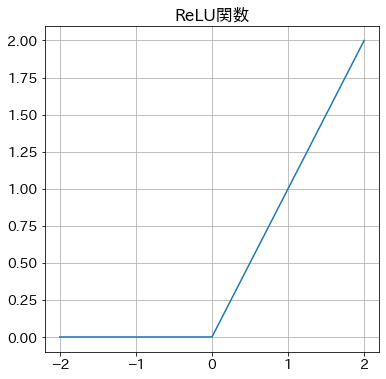

In [6]:
# ReLU関数のグラフ

relu = nn.ReLU()
x_np = np.arange(-2, 2.1, 0.25)
x = torch.tensor(x_np).float()
y = relu(x)

plt.plot(x.data, y.data)
plt.title('ReLU関数')
plt.show()

## 8.4 GPU利用

### GPUチェック

In [7]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
# テスト用tensor変数x , y 
x_np = np.arange(-2.0, 2.1, 0.25)
y_np = np.arange(-1.0, 3.1, 0.25)
x = torch.tensor(x_np).float()
y = torch.tensor(y_np).float()

# xとyの間の演算
z = x * y
print(z)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000])


In [9]:
# 変数xをGPUに送る
x = x.to(device)

# 変数xとyの属性data, deviceの確認
print('x: ', x.device)
print('y: ', y.device)

x:  cuda:0
y:  cpu


In [10]:
# この状態でxとyの演算をすると。。。

z = x * y

RuntimeError: ignored

In [11]:
# yもGPUに送る
y = y.to(device)

# 今度は計算可能になる
z = x * y
print(z)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000], device='cuda:0')


## 8.8 データ準備1 (DataSetによる読み込み)

In [12]:
# ライブラリインポート
import torchvision.datasets as datasets

# ダウンロード先ディレクトリ名
data_root = './data'

train_set0 = datasets.MNIST(
    # 元データダウンロード先の指定
    root = data_root,  
    # 訓練データか検証データか
    train = True,  
    # 元データがない場合にダウンロードするか
    download = True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


In [ ]:
# ダウンロードトラブルに対する回避策
# 普段は実行しなくていいです。
# 上のセルでエラーが発生したらこのセルを実行し、その後で上のセルを再実行して下さい。

datasets.MNIST.resources = [
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
]

In [13]:
# ダウンロードしたファイルの確認

!ls -lR ./data/MNIST

./data/MNIST:
total 8
drwxr-xr-x 2 root root 4096 Apr 10 06:07 processed
drwxr-xr-x 2 root root 4096 Apr 10 06:07 raw

./data/MNIST/processed:
total 54144
-rw-r--r-- 1 root root  7921089 Apr 10 06:07 test.pt
-rw-r--r-- 1 root root 47521089 Apr 10 06:07 training.pt

./data/MNIST/raw:
total 65008
-rw-r--r-- 1 root root  7840016 Apr 10 06:07 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root  1648877 Apr 10 06:07 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    10008 Apr 10 06:07 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root     4542 Apr 10 06:07 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 47040016 Apr 10 06:07 train-images-idx3-ubyte
-rw-r--r-- 1 root root  9912422 Apr 10 06:07 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    60008 Apr 10 06:07 train-labels-idx1-ubyte
-rw-r--r-- 1 root root    28881 Apr 10 06:07 train-labels-idx1-ubyte.gz


In [14]:
# データ件数の確認
print('データ件数: ', len(train_set0))

# 最初の要素の取得
image, label = train_set0[0]

# データ型の確認
print('入力データの型: ', type(image))
print('正解ラベルの型: ', type(label))

データ件数:  60000
入力データの型:  <class 'PIL.Image.Image'>
正解ラベルの型:  <class 'int'>


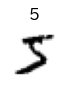

In [15]:
# 入力データの画像表示

plt.figure(figsize=(1,1))
plt.title(f'{label}')
plt.imshow(image, cmap='gray_r')
plt.axis('off')
plt.show()

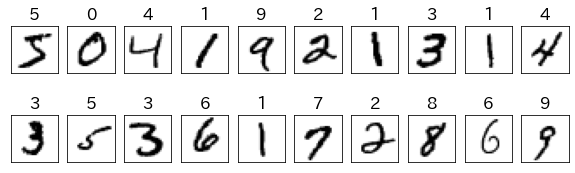

In [16]:
# 正解ラベル付きで、最初の20個をイメージ表示

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    
    # image と labelの取得
    image, label = train_set0[i]
    
    # イメージ表示
    plt.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 8.9 データ準備2 (Transformによるデータ前処理)

### Step1 ToTensorの利用

In [17]:
# ライブラリインポート
import torchvision.transforms as transforms

transform1 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
])

train_set1 = datasets.MNIST(
    root=data_root,  train=True,  download=True,
    transform = transform1)

In [18]:
# 変換結果の確認

image, label = train_set1[0]
print('入力データの型: ', type(image))
print('入力データのshape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

入力データの型:  <class 'torch.Tensor'>
入力データのshape:  torch.Size([1, 28, 28])
最小値:  tensor(0.)
最大値:  tensor(1.)


### Step2 Normalizeの利用

In [19]:
transform2 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
    
    # データの正規化
    transforms.Normalize(0.5,  0.5),
])

train_set2 = datasets.MNIST(
    root = data_root,  train = True,  download = True,
    transform = transform2)

In [20]:
# 変換結果の確認

image, label = train_set2[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([1, 28, 28])
最小値:  tensor(-1.)
最大値:  tensor(1.)


### Step3 Lambdaを利用して1階テンソル化¶

In [21]:
transform3 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
    
    # データの正規化
    transforms.Normalize(0.5, 0.5),
    
    # Tensorの1階テンソル化
    transforms.Lambda(lambda x: x.view(-1)),
])

train_set3 = datasets.MNIST(
    root = data_root,  train = True,  
    download=True, transform = transform3)

In [22]:
# 変換結果の確認

image, label = train_set3[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([784])
最小値:  tensor(-1.)
最大値:  tensor(1.)


### 最終的な実装

In [23]:
# データ変換用関数 Transformer
# (1) Imageをテンソル化
# (2) [0, 1]の範囲の値を[-1, 1]の範囲にする
# (3) データのshapeを[1, 28, 28]から[784]に変換

transform = transforms.Compose([
    # (1) データのテンソル化
    transforms.ToTensor(),
    
    # (2) データの正規化
    transforms.Normalize(0.5, 0.5),
    
    # (3) 1階テンソルに変換
    transforms.Lambda(lambda x: x.view(-1)),
])

In [24]:
# データ取得用関数 DataSet

# 訓練用データセットの定義
train_set = datasets.MNIST(
    root = data_root, train = True,
    download = True, transform = transform)

# 検証データセットの定義
test_set = datasets.MNIST(
    root = data_root, train = False, 
    download = True, transform = transform)

## 8.10 データ準備3 (DataLoaderによるミニバッチ用データ生成)

In [25]:
# ライブラリインポート
from torch.utils.data import DataLoader

# ミニバッチのサイズ指定
batch_size = 500

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set, batch_size = batch_size, 
    shuffle = True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(
    test_set,  batch_size = batch_size, 
    shuffle = False) 

In [26]:
# 何組のデータが取得できるか
print(len(train_loader))

# DataLoaderから最初の1セットを取得する
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

120
torch.Size([500, 784])
torch.Size([500])


In [27]:
print(images.data.max())
print(images.data.min())

tensor(1.)
tensor(-1.)


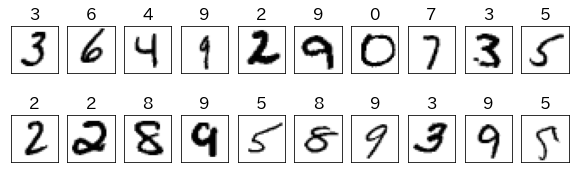

In [28]:
# イメージ表示
plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    
    # numpyに変換
    image = images[i].numpy()
    label = labels[i]
    
    # imgの範囲を[0, 1]に戻す
    image2 = (image + 1)/ 2
    # イメージ表示
    plt.imshow(image2.reshape(28, 28),cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

全体で60000件ある学習データが120個のグループに分割されて取得できていることがわかります。  
今回はテスト用でシャッフルなしでデータを取得しましたが、訓練用データは取得のたびにシャッフルがかかります。  
つまり、ミニバッチ用のデータセットが自動的に取得できていることになります。

## 8.11 モデル定義

In [29]:
# 入力次元数
n_input = image.shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(set(list(labels.data.numpy())))

#   隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 784  n_hidden: 128 n_output: 10


In [30]:
# モデルの定義
# 784入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [31]:
# モデル変数の生成
net = Net(n_input, n_output, n_hidden)

# モデルをGPU側に送る
net = net.to(device)

### 最適化アルゴリズムと損失関数

In [39]:
# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

### モデル確認

In [40]:
# モデル内のパラメータの確認
# l1.weight, l1.bias, l2.weight, l2.biasがあることがわかる

for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[-1.0929e-02,  5.4885e-03, -5.6996e-04,  ...,  3.2554e-02,
          2.9299e-02,  1.6480e-02],
        [-2.3565e-02,  1.4897e-02,  2.0395e-02,  ..., -2.2352e-02,
          7.7191e-04, -3.1465e-02],
        [ 1.2679e-02, -2.8118e-02, -1.0602e-02,  ..., -1.5882e-03,
          2.0386e-02,  2.8689e-02],
        ...,
        [-1.0374e-03, -8.0853e-03,  9.5808e-03,  ..., -1.3274e-03,
          1.5583e-03, -7.7820e-03],
        [-2.2918e-02, -4.2409e-03, -2.7775e-02,  ..., -8.2977e-03,
         -5.4089e-03,  4.9097e-05],
        [-3.3079e-02, -2.7079e-03, -1.4282e-02,  ...,  1.3388e-02,
         -3.3414e-02, -7.3408e-03]], device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([-1.5574e-02,  2.8118e-02,  8.4954e-03,  2.5027e-02, -3.4175e-02,
         1.8938e-02, -2.5016e-02,  2.8747e-02, -3.2114e-03,  6.8854e-03,
         3.1929e-02,  3.3192e-02,  1.8250e-02, -2.2537e-02, -1.0860e-02,
         3.5180e-02,  3.3403e-02,  2.1176

In [41]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [42]:
# モデルのサマリー表示

summary(net, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [128]                     100,480
├─ReLU: 1-2                              [128]                     --
├─Linear: 1-3                            [10]                      1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

## 8.12 勾配降下法

### 予測計算

In [43]:
# 訓練データセット　最初の1項目を取得
# DataLoaderから最初の1セットを取得する
for images, labels in train_loader:
    break 

In [44]:
# Loaderから取得したデータをGPUに送る
inputs = images.to(device)
labels = labels.to(device)

In [45]:
# 予測値の計算
outputs = net(inputs)

# 結果確認
print(outputs)

tensor([[-0.2116,  0.0985,  0.2694,  ...,  0.0239,  0.1583,  0.1004],
        [ 0.0367,  0.0561,  0.2996,  ...,  0.0953,  0.0010,  0.0729],
        [-0.2356,  0.1671,  0.2565,  ...,  0.3428,  0.0710,  0.2436],
        ...,
        [-0.2057,  0.2537,  0.3680,  ...,  0.1282, -0.0292,  0.2991],
        [-0.1961,  0.2116,  0.2927,  ...,  0.2416,  0.1828,  0.0445],
        [-0.2207,  0.0153,  0.1830,  ...,  0.1953, -0.0500,  0.0391]],
       device='cuda:0', grad_fn=<AddmmBackward>)


### 損失関数

#### 損失関数の計算グラフ表示

2.3463845252990723


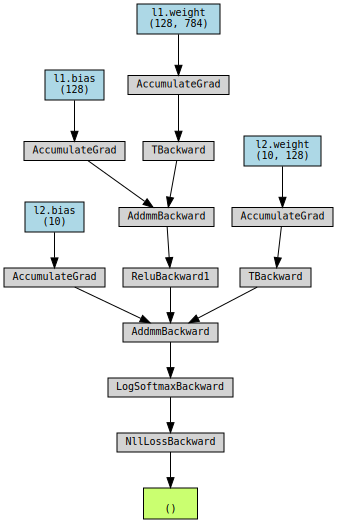

In [46]:
#  損失値の計算
loss = criterion(outputs, labels)

# 損失値の取得
print(loss.item())

# 損失関数のグラフ化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [49]:
graph_pdf(g)

pdf-09-01


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 勾配計算

In [50]:
# 勾配計算の実行
loss.backward()

In [51]:
# 勾配計算の結果
w = net.to('cpu')
print(w.l1.weight.grad.numpy())
print(w.l1.bias.grad.numpy())
print(w.l2.weight.grad.numpy())
print(w.l2.bias.grad.numpy())

[[-0.00055 -0.00055 -0.00055 ... -0.00055 -0.00055 -0.00055]
 [-0.00393 -0.00393 -0.00393 ... -0.00393 -0.00393 -0.00393]
 [-0.00293 -0.00293 -0.00293 ... -0.00293 -0.00293 -0.00293]
 ...
 [ 0.00435  0.00435  0.00435 ...  0.00435  0.00435  0.00435]
 [-0.00407 -0.00407 -0.00407 ... -0.00407 -0.00407 -0.00407]
 [ 0.00203  0.00203  0.00203 ...  0.00203  0.00203  0.00203]]
[ 0.00055  0.00393  0.00293  0.01305  0.00126 -0.00001  0.00516 -0.00294
  0.00499  0.00349 -0.00213  0.01084  0.       0.0016   0.00052  0.00141
 -0.00032 -0.0037  -0.00038  0.00486 -0.00005 -0.00606  0.00049  0.00189
 -0.00402 -0.00078  0.00445 -0.00132  0.00055  0.00031 -0.00169  0.00438
 -0.00091  0.00046  0.00643  0.00252  0.00335 -0.00451  0.00363 -0.00038
  0.00385  0.00241 -0.00064  0.01003 -0.00091  0.00575  0.       0.00035
  0.00502 -0.00041 -0.00009  0.00432  0.00501 -0.00017  0.00081  0.00194
  0.00525  0.00185  0.00535  0.00008 -0.00005 -0.00117 -0.00763  0.00085
  0.00187  0.00281 -0.00014  0.00184  0.0055

### 重み行列の修正

In [52]:
# 勾配降下法の適用
optimizer.step()

In [53]:
# 重み行列の結果
print(net.l1.weight)
print(net.l1.bias)

Parameter containing:
tensor([[-1.0924e-02,  5.4940e-03, -5.6447e-04,  ...,  3.2560e-02,
          2.9305e-02,  1.6485e-02],
        [-2.3526e-02,  1.4936e-02,  2.0435e-02,  ..., -2.2313e-02,
          8.1122e-04, -3.1425e-02],
        [ 1.2709e-02, -2.8088e-02, -1.0573e-02,  ..., -1.5590e-03,
          2.0415e-02,  2.8719e-02],
        ...,
        [-1.0809e-03, -8.1289e-03,  9.5373e-03,  ..., -1.3710e-03,
          1.5148e-03, -7.8255e-03],
        [-2.2877e-02, -4.2002e-03, -2.7734e-02,  ..., -8.2570e-03,
         -5.3682e-03,  8.9821e-05],
        [-3.3099e-02, -2.7282e-03, -1.4303e-02,  ...,  1.3367e-02,
         -3.3435e-02, -7.3611e-03]], requires_grad=True)
Parameter containing:
tensor([-1.5580e-02,  2.8079e-02,  8.4661e-03,  2.4896e-02, -3.4187e-02,
         1.8938e-02, -2.5068e-02,  2.8776e-02, -3.2614e-03,  6.8504e-03,
         3.1950e-02,  3.3084e-02,  1.8250e-02, -2.2553e-02, -1.0865e-02,
         3.5166e-02,  3.3406e-02,  2.1213e-02, -2.4007e-02, -9.0680e-03,
         1.7

### 繰り返し計算

In [57]:
# 乱数の固定化
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# 学習率
lr = 0.01

# モデル初期化
net = Net(n_input, n_output, n_hidden).to(device)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history = np.zeros((0,5))

In [55]:
print(net.l1.weight)

Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0328, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       device='cuda:0', requires_grad=True)


In [59]:
# tqdmライブラリのインポート
from tqdm.notebook import tqdm

# 繰り返し計算メインループ

for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_test = 0, 0

    # 学習フェーズ
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)

        # GPUヘ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        #勾配の初期化
        optimizer.zero_grad()

        # 順伝搬計算
        outputs = net(inputs)

        # 損失計算
        loss = criterion(outputs, labels)

        # 勾配計算
        loss.backward()
    
        # 重み調整
        optimizer.step()

        #予測ラベル導出
        predicted = torch.max(outputs, 1)[1]

        # 訓練データに対する損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum() 

    #予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

            
        # 順伝搬計算
        outputs_test = net(inputs_test)

        # 誤差計算
        loss_test = criterion(outputs_test, labels_test)

        #予測ラベル導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 検証データに対する損失と精度の計算
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))


Epoch [1/100], loss: 1.82906 acc: 0.57452 val_loss: 1.32709, val_acc: 0.73710



Epoch [2/100], loss: 1.03926 acc: 0.79542 val_loss: 0.79728, val_acc: 0.83650



Epoch [3/100], loss: 0.70830 acc: 0.84128 val_loss: 0.60301, val_acc: 0.85960



Epoch [4/100], loss: 0.57295 acc: 0.86123 val_loss: 0.51246, val_acc: 0.87120



Epoch [5/100], loss: 0.50216 acc: 0.87142 val_loss: 0.45811, val_acc: 0.87940



Epoch [6/100], loss: 0.45884 acc: 0.87860 val_loss: 0.42407, val_acc: 0.88680



Epoch [7/100], loss: 0.42953 acc: 0.88365 val_loss: 0.39993, val_acc: 0.89010



Epoch [8/100], loss: 0.40820 acc: 0.88772 val_loss: 0.38284, val_acc: 0.89330



Epoch [9/100], loss: 0.39181 acc: 0.89085 val_loss: 0.36841, val_acc: 0.89680



Epoch [10/100], loss: 0.37872 acc: 0.89342 val_loss: 0.35744, val_acc: 0.89900



Epoch [11/100], loss: 0.36810 acc: 0.89577 val_loss: 0.34819, val_acc: 0.90120



Epoch [12/100], loss: 0.35914 acc: 0.89817 val_loss: 0.34020, val_acc: 0.90330



Epoch [13/100], loss: 0.35136 acc: 0.90000 val_loss: 0.33519, val_acc: 0.90440



Epoch [14/100], loss: 0.34474 acc: 0.90145 val_loss: 0.32816, val_acc: 0.90770



Epoch [15/100], loss: 0.33869 acc: 0.90268 val_loss: 0.32274, val_acc: 0.90850



Epoch [16/100], loss: 0.33308 acc: 0.90427 val_loss: 0.31798, val_acc: 0.90820



Epoch [17/100], loss: 0.32836 acc: 0.90545 val_loss: 0.31324, val_acc: 0.90870



Epoch [18/100], loss: 0.32380 acc: 0.90653 val_loss: 0.30975, val_acc: 0.91080



Epoch [19/100], loss: 0.31961 acc: 0.90805 val_loss: 0.30643, val_acc: 0.91270



Epoch [20/100], loss: 0.31549 acc: 0.90927 val_loss: 0.30323, val_acc: 0.91340



Epoch [21/100], loss: 0.31194 acc: 0.90978 val_loss: 0.29928, val_acc: 0.91510



Epoch [22/100], loss: 0.30832 acc: 0.91127 val_loss: 0.29689, val_acc: 0.91600



Epoch [23/100], loss: 0.30496 acc: 0.91227 val_loss: 0.29413, val_acc: 0.91510



Epoch [24/100], loss: 0.30198 acc: 0.91325 val_loss: 0.29173, val_acc: 0.91610



Epoch [25/100], loss: 0.29869 acc: 0.91408 val_loss: 0.28940, val_acc: 0.91790



Epoch [26/100], loss: 0.29581 acc: 0.91525 val_loss: 0.28609, val_acc: 0.91840



Epoch [27/100], loss: 0.29293 acc: 0.91655 val_loss: 0.28441, val_acc: 0.91960



Epoch [28/100], loss: 0.29010 acc: 0.91695 val_loss: 0.28162, val_acc: 0.91870



Epoch [29/100], loss: 0.28746 acc: 0.91728 val_loss: 0.27873, val_acc: 0.92060



Epoch [30/100], loss: 0.28480 acc: 0.91848 val_loss: 0.27697, val_acc: 0.92110



Epoch [31/100], loss: 0.28211 acc: 0.91935 val_loss: 0.27481, val_acc: 0.92110



Epoch [32/100], loss: 0.27972 acc: 0.91947 val_loss: 0.27254, val_acc: 0.92210



Epoch [33/100], loss: 0.27725 acc: 0.92107 val_loss: 0.27096, val_acc: 0.92250



Epoch [34/100], loss: 0.27490 acc: 0.92137 val_loss: 0.26818, val_acc: 0.92420



Epoch [35/100], loss: 0.27260 acc: 0.92220 val_loss: 0.26619, val_acc: 0.92350



Epoch [36/100], loss: 0.27009 acc: 0.92295 val_loss: 0.26494, val_acc: 0.92420



Epoch [37/100], loss: 0.26798 acc: 0.92368 val_loss: 0.26234, val_acc: 0.92450



Epoch [38/100], loss: 0.26552 acc: 0.92422 val_loss: 0.26119, val_acc: 0.92610



Epoch [39/100], loss: 0.26355 acc: 0.92493 val_loss: 0.25865, val_acc: 0.92590



Epoch [40/100], loss: 0.26115 acc: 0.92525 val_loss: 0.25693, val_acc: 0.92700



Epoch [41/100], loss: 0.25892 acc: 0.92632 val_loss: 0.25645, val_acc: 0.92730



Epoch [42/100], loss: 0.25694 acc: 0.92655 val_loss: 0.25289, val_acc: 0.92770



Epoch [43/100], loss: 0.25468 acc: 0.92742 val_loss: 0.25115, val_acc: 0.92830



Epoch [44/100], loss: 0.25258 acc: 0.92828 val_loss: 0.25133, val_acc: 0.92900



Epoch [45/100], loss: 0.25051 acc: 0.92863 val_loss: 0.24776, val_acc: 0.92910



Epoch [46/100], loss: 0.24841 acc: 0.92933 val_loss: 0.24704, val_acc: 0.92900



Epoch [47/100], loss: 0.24636 acc: 0.92988 val_loss: 0.24342, val_acc: 0.93070



Epoch [48/100], loss: 0.24433 acc: 0.93082 val_loss: 0.24248, val_acc: 0.93140



Epoch [49/100], loss: 0.24237 acc: 0.93115 val_loss: 0.24059, val_acc: 0.93160



Epoch [50/100], loss: 0.24037 acc: 0.93153 val_loss: 0.23850, val_acc: 0.93220



Epoch [51/100], loss: 0.23829 acc: 0.93223 val_loss: 0.23676, val_acc: 0.93340



Epoch [52/100], loss: 0.23647 acc: 0.93275 val_loss: 0.23514, val_acc: 0.93340



Epoch [53/100], loss: 0.23452 acc: 0.93312 val_loss: 0.23325, val_acc: 0.93410



Epoch [54/100], loss: 0.23260 acc: 0.93422 val_loss: 0.23129, val_acc: 0.93450



Epoch [55/100], loss: 0.23072 acc: 0.93448 val_loss: 0.22961, val_acc: 0.93390



Epoch [56/100], loss: 0.22873 acc: 0.93538 val_loss: 0.22790, val_acc: 0.93570



Epoch [57/100], loss: 0.22698 acc: 0.93560 val_loss: 0.22646, val_acc: 0.93600



Epoch [58/100], loss: 0.22518 acc: 0.93650 val_loss: 0.22495, val_acc: 0.93670



Epoch [59/100], loss: 0.22328 acc: 0.93703 val_loss: 0.22300, val_acc: 0.93660



Epoch [60/100], loss: 0.22163 acc: 0.93728 val_loss: 0.22137, val_acc: 0.93690



Epoch [61/100], loss: 0.21973 acc: 0.93803 val_loss: 0.22065, val_acc: 0.93710



Epoch [62/100], loss: 0.21800 acc: 0.93855 val_loss: 0.21772, val_acc: 0.93750



Epoch [63/100], loss: 0.21630 acc: 0.93892 val_loss: 0.21713, val_acc: 0.93770



Epoch [64/100], loss: 0.21461 acc: 0.93983 val_loss: 0.21518, val_acc: 0.93820



Epoch [65/100], loss: 0.21292 acc: 0.94007 val_loss: 0.21319, val_acc: 0.93930



Epoch [66/100], loss: 0.21137 acc: 0.94040 val_loss: 0.21176, val_acc: 0.93990



Epoch [67/100], loss: 0.20959 acc: 0.94068 val_loss: 0.21071, val_acc: 0.93870



Epoch [68/100], loss: 0.20802 acc: 0.94132 val_loss: 0.20884, val_acc: 0.93940



Epoch [69/100], loss: 0.20645 acc: 0.94193 val_loss: 0.20718, val_acc: 0.93990



Epoch [70/100], loss: 0.20475 acc: 0.94227 val_loss: 0.20631, val_acc: 0.94070



Epoch [71/100], loss: 0.20322 acc: 0.94298 val_loss: 0.20517, val_acc: 0.93990



Epoch [72/100], loss: 0.20172 acc: 0.94318 val_loss: 0.20328, val_acc: 0.94020



Epoch [73/100], loss: 0.20019 acc: 0.94368 val_loss: 0.20180, val_acc: 0.94240



Epoch [74/100], loss: 0.19876 acc: 0.94423 val_loss: 0.20043, val_acc: 0.94280



Epoch [75/100], loss: 0.19722 acc: 0.94478 val_loss: 0.19939, val_acc: 0.94210



Epoch [76/100], loss: 0.19578 acc: 0.94485 val_loss: 0.19781, val_acc: 0.94320



Epoch [77/100], loss: 0.19425 acc: 0.94538 val_loss: 0.19625, val_acc: 0.94290



Epoch [78/100], loss: 0.19277 acc: 0.94548 val_loss: 0.19684, val_acc: 0.94270



Epoch [79/100], loss: 0.19151 acc: 0.94627 val_loss: 0.19371, val_acc: 0.94370



Epoch [80/100], loss: 0.19014 acc: 0.94647 val_loss: 0.19321, val_acc: 0.94300



Epoch [81/100], loss: 0.18875 acc: 0.94705 val_loss: 0.19106, val_acc: 0.94460



Epoch [82/100], loss: 0.18739 acc: 0.94712 val_loss: 0.19027, val_acc: 0.94540



Epoch [83/100], loss: 0.18598 acc: 0.94840 val_loss: 0.18919, val_acc: 0.94480



Epoch [84/100], loss: 0.18460 acc: 0.94810 val_loss: 0.18804, val_acc: 0.94480



Epoch [85/100], loss: 0.18341 acc: 0.94850 val_loss: 0.18652, val_acc: 0.94530



Epoch [86/100], loss: 0.18213 acc: 0.94880 val_loss: 0.18528, val_acc: 0.94660



Epoch [87/100], loss: 0.18086 acc: 0.94928 val_loss: 0.18408, val_acc: 0.94620



Epoch [88/100], loss: 0.17961 acc: 0.94977 val_loss: 0.18267, val_acc: 0.94650



Epoch [89/100], loss: 0.17840 acc: 0.95015 val_loss: 0.18173, val_acc: 0.94720



Epoch [90/100], loss: 0.17710 acc: 0.95052 val_loss: 0.18066, val_acc: 0.94740



Epoch [91/100], loss: 0.17595 acc: 0.95073 val_loss: 0.18018, val_acc: 0.94720



Epoch [92/100], loss: 0.17479 acc: 0.95115 val_loss: 0.17874, val_acc: 0.94770



Epoch [93/100], loss: 0.17355 acc: 0.95172 val_loss: 0.17739, val_acc: 0.94790



Epoch [94/100], loss: 0.17243 acc: 0.95198 val_loss: 0.17654, val_acc: 0.94790



Epoch [95/100], loss: 0.17130 acc: 0.95223 val_loss: 0.17545, val_acc: 0.94750



Epoch [96/100], loss: 0.17016 acc: 0.95233 val_loss: 0.17445, val_acc: 0.94810



Epoch [97/100], loss: 0.16907 acc: 0.95323 val_loss: 0.17346, val_acc: 0.94880



Epoch [98/100], loss: 0.16786 acc: 0.95343 val_loss: 0.17271, val_acc: 0.94850



Epoch [99/100], loss: 0.16702 acc: 0.95350 val_loss: 0.17238, val_acc: 0.94890



Epoch [100/100], loss: 0.16581 acc: 0.95343 val_loss: 0.17156, val_acc: 0.94870


## 8.13 結果確認

In [61]:
#損失関数値と精度の確認

print(f'初期状態: 損失関数値: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失関数値: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失関数値: 1.32709 精度: 0.73710
最終状態: 損失関数値: 0.17156 精度: 0.94870


pdf-09-02.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

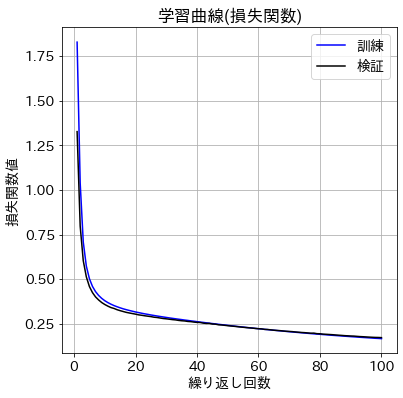

In [62]:
# 学習曲線の表示 (損失関数)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.title('学習曲線(損失関数)')
plt.legend()
create_pdf(plt)
plt.show()

pdf-09-03.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

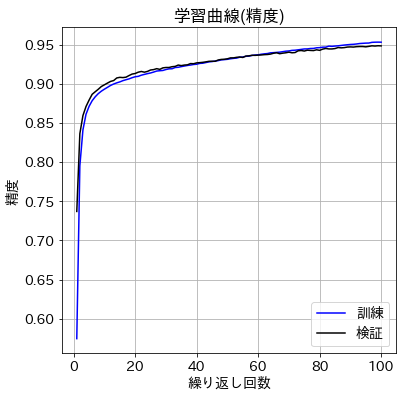

In [63]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
create_pdf(plt)
plt.show()

### イメージ表示で確認

In [64]:
# DataLoaderから最初の1セットを取得する
for images, labels in test_loader:
    break

# 予測結果の取得
inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
predicted = torch.max(outputs, 1)[1]

pdf-09-04.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

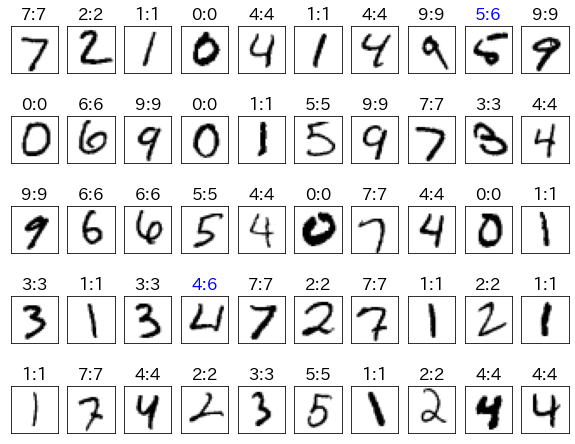

In [65]:
# 最初の50件でイメージを「正解値:予測値」と表示

plt.figure(figsize=(10, 8))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
    
  # numpyに変換
  image = images[i]
  label = labels[i]
  pred = predicted[i]
  if (pred == label):
    c = 'k'
  else:
    c = 'b'
    
  # imgの範囲を[0, 1]に戻す
  image2 = (image + 1)/ 2
    
  # イメージ表示
  plt.imshow(image2.reshape(28, 28),cmap='gray_r')
  ax.set_title(f'{label}:{pred}', c=c)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
create_pdf(plt)
plt.show()


## 8.14 隠れ層の2層化

In [66]:
# モデルの定義
# 784入力10出力2隠れ層のニューラルネットワークモデル

class Net2(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        
        # 隠れ層1の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 隠れ層2の定義 (隠れ層のノード数: n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)

        # 出力層の定義
        self.l3 = nn.Linear(n_hidden, n_output)

        # Relu関数の定義
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        return x5

In [ ]:
# インスタンスの生成
net = Net2(n_input, n_output, n_hidden).to(device)

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

In [ ]:
# モデルの概要表示

print(net)

Net2(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [ ]:
# モデルのサマリー表示

summary(net, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.45
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


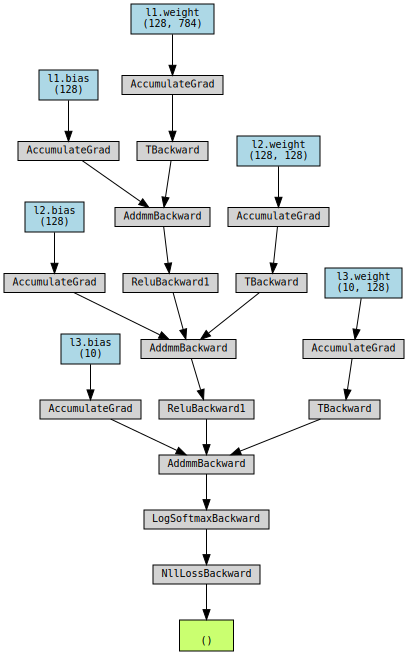

In [ ]:
# 予測値の計算
outputs = net(inputs)

#  損失値の計算
loss = criterion(outputs, labels)

# 損失関数のグラフ化
make_dot(loss, params=dict(net.named_parameters()))

### 勾配計算

In [ ]:
# 勾配計算の実行
loss.backward()

# 勾配計算結果の一部
w = net.to('cpu')
print(w.l1.weight.grad.numpy())

[[ 0.00078  0.00078  0.00078 ...  0.00078  0.00078  0.00078]
 [-0.0003  -0.0003  -0.0003  ... -0.0003  -0.0003  -0.0003 ]
 [-0.00069 -0.00069 -0.00069 ... -0.00069 -0.00069 -0.00069]
 ...
 [-0.00005 -0.00005 -0.00005 ... -0.00005 -0.00005 -0.00005]
 [ 0.00002  0.00002  0.00002 ...  0.00002  0.00002  0.00002]
 [-0.00174 -0.00174 -0.00174 ... -0.00174 -0.00174 -0.00174]]


In [67]:
# 乱数の固定化
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# 初期化
net = Net2(n_input, n_output, n_hidden).to(device)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 200

# 評価結果記録用
history2 = np.zeros((0,5))

In [68]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):
    train_acc = 0
    train_loss = 0
    val_acc = 0
    val_loss = 0
    n_train = 0
    n_test = 0

    # 学習フェーズ
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)

        # GPUヘ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        #勾配の初期化
        optimizer.zero_grad()

        # 順伝搬計算
        outputs = net(inputs)

        # 損失計算
        loss = criterion(outputs, labels)

        # 勾配計算
        loss.backward()
    
        # 重み調整
        optimizer.step()

        #予測ラベル導出
        predicted = torch.max(outputs, 1)[1]

        # 訓練データに対する損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum() 

    #予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 順伝搬計算
        outputs_test = net(inputs_test)

        # 誤差計算
        loss_test = criterion(outputs_test, labels_test)

        #予測ラベル導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 検証データに対する損失と精度の計算
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history2 = np.vstack((history2, item))


Epoch [1/200], loss: 2.20237 acc: 0.25737 val_loss: 2.04650, val_acc: 0.47240



Epoch [2/200], loss: 1.75686 acc: 0.59707 val_loss: 1.38974, val_acc: 0.71280



Epoch [3/200], loss: 1.11007 acc: 0.75915 val_loss: 0.86246, val_acc: 0.80520



Epoch [4/200], loss: 0.74921 acc: 0.82358 val_loss: 0.63268, val_acc: 0.84380



Epoch [5/200], loss: 0.58864 acc: 0.85085 val_loss: 0.52330, val_acc: 0.86380



Epoch [6/200], loss: 0.50581 acc: 0.86617 val_loss: 0.46134, val_acc: 0.87750



Epoch [7/200], loss: 0.45582 acc: 0.87610 val_loss: 0.42253, val_acc: 0.88590



Epoch [8/200], loss: 0.42269 acc: 0.88195 val_loss: 0.39456, val_acc: 0.89030



Epoch [9/200], loss: 0.39919 acc: 0.88803 val_loss: 0.37452, val_acc: 0.89610



Epoch [10/200], loss: 0.38134 acc: 0.89198 val_loss: 0.35890, val_acc: 0.89840



Epoch [11/200], loss: 0.36749 acc: 0.89492 val_loss: 0.34771, val_acc: 0.90210



Epoch [12/200], loss: 0.35570 acc: 0.89747 val_loss: 0.33597, val_acc: 0.90450



Epoch [13/200], loss: 0.34593 acc: 0.90027 val_loss: 0.32889, val_acc: 0.90560



Epoch [14/200], loss: 0.33760 acc: 0.90290 val_loss: 0.31996, val_acc: 0.90920



Epoch [15/200], loss: 0.33000 acc: 0.90407 val_loss: 0.31450, val_acc: 0.90830



Epoch [16/200], loss: 0.32329 acc: 0.90563 val_loss: 0.30754, val_acc: 0.91090



Epoch [17/200], loss: 0.31688 acc: 0.90785 val_loss: 0.30271, val_acc: 0.91290



Epoch [18/200], loss: 0.31155 acc: 0.90955 val_loss: 0.29821, val_acc: 0.91220



Epoch [19/200], loss: 0.30642 acc: 0.91070 val_loss: 0.29301, val_acc: 0.91440



Epoch [20/200], loss: 0.30139 acc: 0.91218 val_loss: 0.28992, val_acc: 0.91670



Epoch [21/200], loss: 0.29690 acc: 0.91395 val_loss: 0.28493, val_acc: 0.91760



Epoch [22/200], loss: 0.29275 acc: 0.91495 val_loss: 0.28155, val_acc: 0.91880



Epoch [23/200], loss: 0.28867 acc: 0.91583 val_loss: 0.27855, val_acc: 0.92050



Epoch [24/200], loss: 0.28490 acc: 0.91715 val_loss: 0.27586, val_acc: 0.92040



Epoch [25/200], loss: 0.28103 acc: 0.91828 val_loss: 0.27386, val_acc: 0.92220



Epoch [26/200], loss: 0.27749 acc: 0.91942 val_loss: 0.26981, val_acc: 0.92250



Epoch [27/200], loss: 0.27408 acc: 0.92043 val_loss: 0.26595, val_acc: 0.92270



Epoch [28/200], loss: 0.27063 acc: 0.92100 val_loss: 0.26328, val_acc: 0.92410



Epoch [29/200], loss: 0.26752 acc: 0.92198 val_loss: 0.25994, val_acc: 0.92530



Epoch [30/200], loss: 0.26398 acc: 0.92302 val_loss: 0.25778, val_acc: 0.92440



Epoch [31/200], loss: 0.26119 acc: 0.92390 val_loss: 0.25460, val_acc: 0.92660



Epoch [32/200], loss: 0.25817 acc: 0.92512 val_loss: 0.25260, val_acc: 0.92660



Epoch [33/200], loss: 0.25508 acc: 0.92590 val_loss: 0.24956, val_acc: 0.92810



Epoch [34/200], loss: 0.25229 acc: 0.92692 val_loss: 0.24667, val_acc: 0.92930



Epoch [35/200], loss: 0.24945 acc: 0.92737 val_loss: 0.24507, val_acc: 0.92710



Epoch [36/200], loss: 0.24661 acc: 0.92848 val_loss: 0.24315, val_acc: 0.92950



Epoch [37/200], loss: 0.24379 acc: 0.92928 val_loss: 0.23959, val_acc: 0.93010



Epoch [38/200], loss: 0.24123 acc: 0.93055 val_loss: 0.23820, val_acc: 0.93120



Epoch [39/200], loss: 0.23847 acc: 0.93157 val_loss: 0.23563, val_acc: 0.93130



Epoch [40/200], loss: 0.23579 acc: 0.93192 val_loss: 0.23231, val_acc: 0.93310



Epoch [41/200], loss: 0.23321 acc: 0.93258 val_loss: 0.23116, val_acc: 0.93240



Epoch [42/200], loss: 0.23061 acc: 0.93325 val_loss: 0.22778, val_acc: 0.93460



Epoch [43/200], loss: 0.22812 acc: 0.93423 val_loss: 0.22582, val_acc: 0.93240



Epoch [44/200], loss: 0.22566 acc: 0.93475 val_loss: 0.22391, val_acc: 0.93490



Epoch [45/200], loss: 0.22306 acc: 0.93555 val_loss: 0.22072, val_acc: 0.93540



Epoch [46/200], loss: 0.22040 acc: 0.93592 val_loss: 0.21869, val_acc: 0.93630



Epoch [47/200], loss: 0.21825 acc: 0.93705 val_loss: 0.21621, val_acc: 0.93580



Epoch [48/200], loss: 0.21568 acc: 0.93727 val_loss: 0.21561, val_acc: 0.93840



Epoch [49/200], loss: 0.21343 acc: 0.93838 val_loss: 0.21197, val_acc: 0.93760



Epoch [50/200], loss: 0.21090 acc: 0.93960 val_loss: 0.21001, val_acc: 0.93900



Epoch [51/200], loss: 0.20869 acc: 0.93990 val_loss: 0.20778, val_acc: 0.93890



Epoch [52/200], loss: 0.20636 acc: 0.94030 val_loss: 0.20686, val_acc: 0.94040



Epoch [53/200], loss: 0.20413 acc: 0.94122 val_loss: 0.20369, val_acc: 0.93910



Epoch [54/200], loss: 0.20185 acc: 0.94205 val_loss: 0.20166, val_acc: 0.94180



Epoch [55/200], loss: 0.19984 acc: 0.94252 val_loss: 0.20036, val_acc: 0.94170



Epoch [56/200], loss: 0.19784 acc: 0.94303 val_loss: 0.19801, val_acc: 0.94260



Epoch [57/200], loss: 0.19563 acc: 0.94352 val_loss: 0.19679, val_acc: 0.94280



Epoch [58/200], loss: 0.19369 acc: 0.94402 val_loss: 0.19415, val_acc: 0.94120



Epoch [59/200], loss: 0.19159 acc: 0.94480 val_loss: 0.19188, val_acc: 0.94370



Epoch [60/200], loss: 0.18954 acc: 0.94515 val_loss: 0.19036, val_acc: 0.94260



Epoch [61/200], loss: 0.18744 acc: 0.94633 val_loss: 0.18776, val_acc: 0.94380



Epoch [62/200], loss: 0.18534 acc: 0.94655 val_loss: 0.18828, val_acc: 0.94550



Epoch [63/200], loss: 0.18371 acc: 0.94705 val_loss: 0.18543, val_acc: 0.94500



Epoch [64/200], loss: 0.18171 acc: 0.94825 val_loss: 0.18293, val_acc: 0.94520



Epoch [65/200], loss: 0.17983 acc: 0.94832 val_loss: 0.18132, val_acc: 0.94560



Epoch [66/200], loss: 0.17814 acc: 0.94870 val_loss: 0.18017, val_acc: 0.94730



Epoch [67/200], loss: 0.17622 acc: 0.94890 val_loss: 0.17902, val_acc: 0.94820



Epoch [68/200], loss: 0.17468 acc: 0.94972 val_loss: 0.17657, val_acc: 0.94810



Epoch [69/200], loss: 0.17273 acc: 0.95073 val_loss: 0.17514, val_acc: 0.94870



Epoch [70/200], loss: 0.17111 acc: 0.95098 val_loss: 0.17314, val_acc: 0.94870



Epoch [71/200], loss: 0.16942 acc: 0.95152 val_loss: 0.17229, val_acc: 0.94940



Epoch [72/200], loss: 0.16780 acc: 0.95173 val_loss: 0.17097, val_acc: 0.94960



Epoch [73/200], loss: 0.16611 acc: 0.95248 val_loss: 0.16833, val_acc: 0.95020



Epoch [74/200], loss: 0.16450 acc: 0.95292 val_loss: 0.16831, val_acc: 0.94980



Epoch [75/200], loss: 0.16294 acc: 0.95310 val_loss: 0.16692, val_acc: 0.95000



Epoch [76/200], loss: 0.16130 acc: 0.95380 val_loss: 0.16540, val_acc: 0.95100



Epoch [77/200], loss: 0.15960 acc: 0.95443 val_loss: 0.16332, val_acc: 0.95220



Epoch [78/200], loss: 0.15835 acc: 0.95472 val_loss: 0.16229, val_acc: 0.95100



Epoch [79/200], loss: 0.15663 acc: 0.95513 val_loss: 0.16134, val_acc: 0.95260



Epoch [80/200], loss: 0.15545 acc: 0.95528 val_loss: 0.15947, val_acc: 0.95310



Epoch [81/200], loss: 0.15383 acc: 0.95597 val_loss: 0.15933, val_acc: 0.95220



Epoch [82/200], loss: 0.15251 acc: 0.95653 val_loss: 0.15719, val_acc: 0.95290



Epoch [83/200], loss: 0.15101 acc: 0.95670 val_loss: 0.15668, val_acc: 0.95320



Epoch [84/200], loss: 0.14974 acc: 0.95698 val_loss: 0.15512, val_acc: 0.95310



Epoch [85/200], loss: 0.14813 acc: 0.95768 val_loss: 0.15368, val_acc: 0.95360



Epoch [86/200], loss: 0.14677 acc: 0.95795 val_loss: 0.15199, val_acc: 0.95480



Epoch [87/200], loss: 0.14557 acc: 0.95870 val_loss: 0.15086, val_acc: 0.95490



Epoch [88/200], loss: 0.14434 acc: 0.95873 val_loss: 0.15018, val_acc: 0.95530



Epoch [89/200], loss: 0.14311 acc: 0.95910 val_loss: 0.14935, val_acc: 0.95460



Epoch [90/200], loss: 0.14193 acc: 0.95948 val_loss: 0.14761, val_acc: 0.95610



Epoch [91/200], loss: 0.14071 acc: 0.95995 val_loss: 0.14634, val_acc: 0.95610



Epoch [92/200], loss: 0.13928 acc: 0.96040 val_loss: 0.14620, val_acc: 0.95630



Epoch [93/200], loss: 0.13804 acc: 0.96080 val_loss: 0.14423, val_acc: 0.95660



Epoch [94/200], loss: 0.13685 acc: 0.96115 val_loss: 0.14406, val_acc: 0.95700



Epoch [95/200], loss: 0.13575 acc: 0.96093 val_loss: 0.14327, val_acc: 0.95660



Epoch [96/200], loss: 0.13462 acc: 0.96170 val_loss: 0.14226, val_acc: 0.95720



Epoch [97/200], loss: 0.13345 acc: 0.96188 val_loss: 0.14064, val_acc: 0.95730



Epoch [98/200], loss: 0.13226 acc: 0.96263 val_loss: 0.13943, val_acc: 0.95760



Epoch [99/200], loss: 0.13101 acc: 0.96260 val_loss: 0.13937, val_acc: 0.95800



Epoch [100/200], loss: 0.12998 acc: 0.96362 val_loss: 0.13882, val_acc: 0.95850



Epoch [101/200], loss: 0.12886 acc: 0.96312 val_loss: 0.13745, val_acc: 0.95840



Epoch [102/200], loss: 0.12769 acc: 0.96347 val_loss: 0.13749, val_acc: 0.95900



Epoch [103/200], loss: 0.12665 acc: 0.96428 val_loss: 0.13563, val_acc: 0.95840



Epoch [104/200], loss: 0.12579 acc: 0.96427 val_loss: 0.13498, val_acc: 0.95900



Epoch [105/200], loss: 0.12477 acc: 0.96455 val_loss: 0.13427, val_acc: 0.95880



Epoch [106/200], loss: 0.12374 acc: 0.96472 val_loss: 0.13269, val_acc: 0.95890



Epoch [107/200], loss: 0.12255 acc: 0.96498 val_loss: 0.13198, val_acc: 0.96030



Epoch [108/200], loss: 0.12177 acc: 0.96560 val_loss: 0.13166, val_acc: 0.96020



Epoch [109/200], loss: 0.12058 acc: 0.96573 val_loss: 0.13159, val_acc: 0.95970



Epoch [110/200], loss: 0.11957 acc: 0.96605 val_loss: 0.12977, val_acc: 0.96140



Epoch [111/200], loss: 0.11877 acc: 0.96598 val_loss: 0.12903, val_acc: 0.96110



Epoch [112/200], loss: 0.11777 acc: 0.96640 val_loss: 0.12838, val_acc: 0.96090



Epoch [113/200], loss: 0.11684 acc: 0.96675 val_loss: 0.12754, val_acc: 0.96120



Epoch [114/200], loss: 0.11579 acc: 0.96717 val_loss: 0.12658, val_acc: 0.96110



Epoch [115/200], loss: 0.11500 acc: 0.96712 val_loss: 0.12697, val_acc: 0.96170



Epoch [116/200], loss: 0.11397 acc: 0.96740 val_loss: 0.12567, val_acc: 0.96170



Epoch [117/200], loss: 0.11323 acc: 0.96783 val_loss: 0.12466, val_acc: 0.96280



Epoch [118/200], loss: 0.11226 acc: 0.96807 val_loss: 0.12369, val_acc: 0.96250



Epoch [119/200], loss: 0.11135 acc: 0.96850 val_loss: 0.12297, val_acc: 0.96200



Epoch [120/200], loss: 0.11051 acc: 0.96848 val_loss: 0.12358, val_acc: 0.96230



Epoch [121/200], loss: 0.10973 acc: 0.96910 val_loss: 0.12170, val_acc: 0.96300



Epoch [122/200], loss: 0.10868 acc: 0.96930 val_loss: 0.12120, val_acc: 0.96330



Epoch [123/200], loss: 0.10798 acc: 0.96950 val_loss: 0.12082, val_acc: 0.96310



Epoch [124/200], loss: 0.10716 acc: 0.96955 val_loss: 0.11936, val_acc: 0.96350



Epoch [125/200], loss: 0.10633 acc: 0.96992 val_loss: 0.11926, val_acc: 0.96340



Epoch [126/200], loss: 0.10543 acc: 0.97010 val_loss: 0.11897, val_acc: 0.96340



Epoch [127/200], loss: 0.10467 acc: 0.97050 val_loss: 0.11822, val_acc: 0.96410



Epoch [128/200], loss: 0.10402 acc: 0.97043 val_loss: 0.11726, val_acc: 0.96420



Epoch [129/200], loss: 0.10299 acc: 0.97087 val_loss: 0.11652, val_acc: 0.96510



Epoch [130/200], loss: 0.10237 acc: 0.97088 val_loss: 0.11615, val_acc: 0.96480



Epoch [131/200], loss: 0.10169 acc: 0.97120 val_loss: 0.11640, val_acc: 0.96530



Epoch [132/200], loss: 0.10090 acc: 0.97177 val_loss: 0.11546, val_acc: 0.96450



Epoch [133/200], loss: 0.10013 acc: 0.97158 val_loss: 0.11434, val_acc: 0.96590



Epoch [134/200], loss: 0.09946 acc: 0.97208 val_loss: 0.11395, val_acc: 0.96530



Epoch [135/200], loss: 0.09858 acc: 0.97193 val_loss: 0.11326, val_acc: 0.96590



Epoch [136/200], loss: 0.09800 acc: 0.97255 val_loss: 0.11244, val_acc: 0.96640



Epoch [137/200], loss: 0.09726 acc: 0.97255 val_loss: 0.11257, val_acc: 0.96640



Epoch [138/200], loss: 0.09644 acc: 0.97308 val_loss: 0.11232, val_acc: 0.96570



Epoch [139/200], loss: 0.09574 acc: 0.97303 val_loss: 0.11118, val_acc: 0.96580



Epoch [140/200], loss: 0.09513 acc: 0.97323 val_loss: 0.11069, val_acc: 0.96590



Epoch [141/200], loss: 0.09435 acc: 0.97403 val_loss: 0.11012, val_acc: 0.96630



Epoch [142/200], loss: 0.09363 acc: 0.97398 val_loss: 0.10981, val_acc: 0.96620



Epoch [143/200], loss: 0.09304 acc: 0.97398 val_loss: 0.10920, val_acc: 0.96650



Epoch [144/200], loss: 0.09240 acc: 0.97440 val_loss: 0.10862, val_acc: 0.96690



Epoch [145/200], loss: 0.09179 acc: 0.97420 val_loss: 0.10889, val_acc: 0.96630



Epoch [146/200], loss: 0.09096 acc: 0.97508 val_loss: 0.10834, val_acc: 0.96670



Epoch [147/200], loss: 0.09052 acc: 0.97455 val_loss: 0.10734, val_acc: 0.96750



Epoch [148/200], loss: 0.08977 acc: 0.97545 val_loss: 0.10643, val_acc: 0.96770



Epoch [149/200], loss: 0.08913 acc: 0.97493 val_loss: 0.10641, val_acc: 0.96740



Epoch [150/200], loss: 0.08841 acc: 0.97538 val_loss: 0.10555, val_acc: 0.96820



Epoch [151/200], loss: 0.08780 acc: 0.97545 val_loss: 0.10569, val_acc: 0.96810



Epoch [152/200], loss: 0.08736 acc: 0.97560 val_loss: 0.10517, val_acc: 0.96780



Epoch [153/200], loss: 0.08671 acc: 0.97597 val_loss: 0.10525, val_acc: 0.96790



Epoch [154/200], loss: 0.08615 acc: 0.97598 val_loss: 0.10553, val_acc: 0.96830



Epoch [155/200], loss: 0.08549 acc: 0.97672 val_loss: 0.10426, val_acc: 0.96810



Epoch [156/200], loss: 0.08490 acc: 0.97650 val_loss: 0.10402, val_acc: 0.96920



Epoch [157/200], loss: 0.08419 acc: 0.97687 val_loss: 0.10325, val_acc: 0.96850



Epoch [158/200], loss: 0.08379 acc: 0.97697 val_loss: 0.10231, val_acc: 0.96840



Epoch [159/200], loss: 0.08319 acc: 0.97688 val_loss: 0.10198, val_acc: 0.96860



Epoch [160/200], loss: 0.08260 acc: 0.97725 val_loss: 0.10186, val_acc: 0.96910



Epoch [161/200], loss: 0.08193 acc: 0.97713 val_loss: 0.10141, val_acc: 0.96870



Epoch [162/200], loss: 0.08150 acc: 0.97763 val_loss: 0.10130, val_acc: 0.96930



Epoch [163/200], loss: 0.08098 acc: 0.97728 val_loss: 0.10032, val_acc: 0.96930



Epoch [164/200], loss: 0.08039 acc: 0.97763 val_loss: 0.10002, val_acc: 0.96940



Epoch [165/200], loss: 0.07988 acc: 0.97788 val_loss: 0.09946, val_acc: 0.96850



Epoch [166/200], loss: 0.07941 acc: 0.97822 val_loss: 0.09875, val_acc: 0.96940



Epoch [167/200], loss: 0.07884 acc: 0.97790 val_loss: 0.09901, val_acc: 0.96950



Epoch [168/200], loss: 0.07840 acc: 0.97825 val_loss: 0.09946, val_acc: 0.97040



Epoch [169/200], loss: 0.07770 acc: 0.97850 val_loss: 0.09870, val_acc: 0.96930



Epoch [170/200], loss: 0.07740 acc: 0.97862 val_loss: 0.09804, val_acc: 0.96960



Epoch [171/200], loss: 0.07686 acc: 0.97908 val_loss: 0.09745, val_acc: 0.96990



Epoch [172/200], loss: 0.07624 acc: 0.97922 val_loss: 0.09810, val_acc: 0.96940



Epoch [173/200], loss: 0.07578 acc: 0.97907 val_loss: 0.09669, val_acc: 0.97020



Epoch [174/200], loss: 0.07536 acc: 0.97930 val_loss: 0.09617, val_acc: 0.97010



Epoch [175/200], loss: 0.07485 acc: 0.97938 val_loss: 0.09708, val_acc: 0.97020



Epoch [176/200], loss: 0.07440 acc: 0.97940 val_loss: 0.09606, val_acc: 0.96980



Epoch [177/200], loss: 0.07381 acc: 0.97963 val_loss: 0.09544, val_acc: 0.97030



Epoch [178/200], loss: 0.07339 acc: 0.97962 val_loss: 0.09733, val_acc: 0.96990



Epoch [179/200], loss: 0.07312 acc: 0.97993 val_loss: 0.09487, val_acc: 0.97040



Epoch [180/200], loss: 0.07249 acc: 0.98012 val_loss: 0.09426, val_acc: 0.97090



Epoch [181/200], loss: 0.07197 acc: 0.98030 val_loss: 0.09580, val_acc: 0.97060



Epoch [182/200], loss: 0.07157 acc: 0.98028 val_loss: 0.09477, val_acc: 0.97000



Epoch [183/200], loss: 0.07121 acc: 0.98020 val_loss: 0.09388, val_acc: 0.97080



Epoch [184/200], loss: 0.07067 acc: 0.98028 val_loss: 0.09400, val_acc: 0.97100



Epoch [185/200], loss: 0.07026 acc: 0.98070 val_loss: 0.09475, val_acc: 0.97070



Epoch [186/200], loss: 0.06988 acc: 0.98037 val_loss: 0.09266, val_acc: 0.97100



Epoch [187/200], loss: 0.06939 acc: 0.98065 val_loss: 0.09261, val_acc: 0.97100



Epoch [188/200], loss: 0.06893 acc: 0.98113 val_loss: 0.09253, val_acc: 0.97110



Epoch [189/200], loss: 0.06860 acc: 0.98078 val_loss: 0.09238, val_acc: 0.97200



Epoch [190/200], loss: 0.06813 acc: 0.98132 val_loss: 0.09168, val_acc: 0.97120



Epoch [191/200], loss: 0.06766 acc: 0.98127 val_loss: 0.09225, val_acc: 0.97170



Epoch [192/200], loss: 0.06732 acc: 0.98137 val_loss: 0.09191, val_acc: 0.97090



Epoch [193/200], loss: 0.06691 acc: 0.98138 val_loss: 0.09045, val_acc: 0.97130



Epoch [194/200], loss: 0.06657 acc: 0.98183 val_loss: 0.09103, val_acc: 0.97130



Epoch [195/200], loss: 0.06618 acc: 0.98183 val_loss: 0.09032, val_acc: 0.97140



Epoch [196/200], loss: 0.06568 acc: 0.98210 val_loss: 0.09001, val_acc: 0.97250



Epoch [197/200], loss: 0.06521 acc: 0.98230 val_loss: 0.09012, val_acc: 0.97140



Epoch [198/200], loss: 0.06477 acc: 0.98242 val_loss: 0.08990, val_acc: 0.97230



Epoch [199/200], loss: 0.06443 acc: 0.98252 val_loss: 0.08971, val_acc: 0.97230



Epoch [200/200], loss: 0.06420 acc: 0.98245 val_loss: 0.08978, val_acc: 0.97130


In [69]:
#損失関数値と精度の確認

print(f'初期状態: 損失関数値: {history2[0,3]:.5f} 精度: {history2[0,4]:.5f}' )
print(f'最終状態: 損失関数値: {history2[-1,3]:.5f} 精度: {history2[-1,4]:.5f}' )

初期状態: 損失関数値: 2.04650 精度: 0.47240
最終状態: 損失関数値: 0.08978 精度: 0.97130


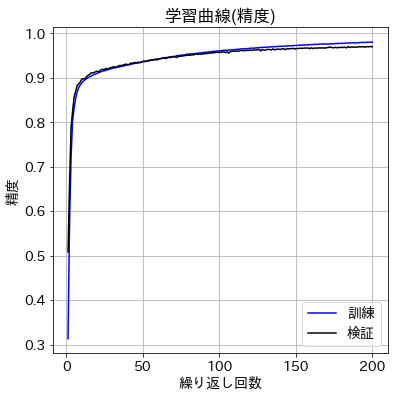

In [ ]:
# 学習曲線の表示 (精度)

plt.plot(history2[:,0], history2[:,2], 'b', label='訓練')
plt.plot(history2[:,0], history2[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

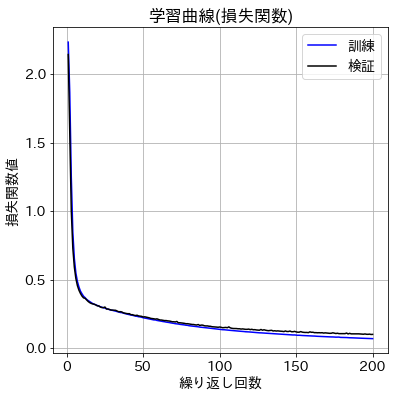

In [ ]:
# 学習曲線の表示 (損失関数)
plt.plot(history2[:,0], history2[:,1], 'b', label='訓練')
plt.plot(history2[:,0], history2[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.title('学習曲線(損失関数)')
plt.legend()
plt.show()

## コラム　勾配消失とReLU関数

In [ ]:
# モデルの定義　シグモイド関数バージョン
# 784入力10出力2隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        
        # 隠れ層1の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 隠れ層2の定義 (隠れ層のノード数: n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)

        # 出力層の定義
        self.l3 = nn.Linear(n_hidden, n_output)

        # シグモイド関数の定義
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.sigmoid(x1)
        x3 = self.l2(x2)
        x4 = self.sigmoid(x3)
        x5 = self.l3(x4)
        return x5

In [ ]:
# インスタンスの生成
net = Net(n_input, n_output, n_hidden).to(device)

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

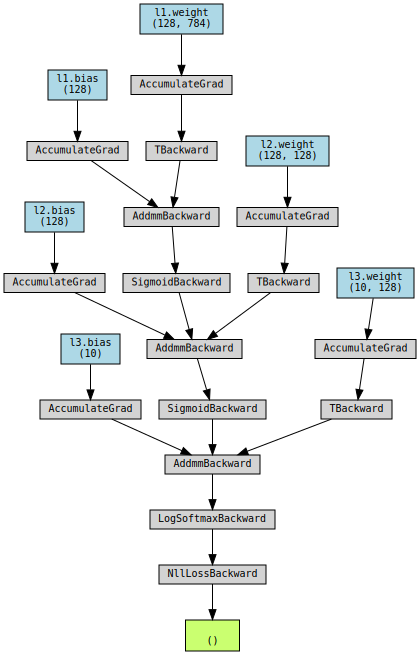

In [ ]:
# 予測値の計算
outputs = net(inputs)

#  損失値の計算
loss = criterion(outputs, labels)

# 損失関数のグラフ化
make_dot(loss, params=dict(net.named_parameters()))

In [ ]:
# 勾配計算の実行
loss.backward()

# 勾配計算結果の一部
w = net.to('cpu')
print(w.l1.weight.grad.numpy())

[[-0.00009 -0.00009 -0.00009 ... -0.00009 -0.00009 -0.00009]
 [-0.      -0.      -0.      ... -0.      -0.      -0.     ]
 [ 0.0001   0.0001   0.0001  ...  0.0001   0.0001   0.0001 ]
 ...
 [ 0.0002   0.0002   0.0002  ...  0.0002   0.0002   0.0002 ]
 [-0.00012 -0.00012 -0.00012 ... -0.00012 -0.00012 -0.00012]
 [ 0.00014  0.00014  0.00014 ...  0.00014  0.00014  0.00014]]


## コラム　lambda式による関数定義

In [ ]:
# 通常の関数定義

def f(x):
    return (2 * x**2 + 2)

In [ ]:
x = np.arange(-2, 2.1, 0.25)
y = f(x)
print(y)

[10.     8.125  6.5    5.125  4.     3.125  2.5    2.125  2.     2.125
  2.5    3.125  4.     5.125  6.5    8.125 10.   ]


In [ ]:
# lambda式による関数定義

g = lambda x: 2 * x**2 + 2

In [ ]:
y = g(x)
print(y)

[10.     8.125  6.5    5.125  4.     3.125  2.5    2.125  2.     2.125
  2.5    3.125  4.     5.125  6.5    8.125 10.   ]


## コラム 「ディープラーニングの数学」との結果比較

### fit関数の定義

In [ ]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):
    base_epochs = len(history)
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 順伝搬計算
            outputs = net(inputs)

            # 誤差計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # 重み変更
            optimizer.step()

            #予測値算出
            predicted = torch.max(outputs, 1)[1]

            #正解件数算出
            train_acc += (predicted == labels).sum()

            # 訓練データに対する損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)

            inputs = inputs.to(device)
            labels = labels.to(device)

            # 順伝搬計算
            outputs = net(inputs)

            # 誤差計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            #予測値算出
            predicted = torch.max(outputs, 1)[1]

            #正解件数算出
            val_acc += (predicted == labels).sum()

            # 検証データに対する損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

### 訓練データでbatch_size=200に変更

In [ ]:
# ミニバッチのサイズ指定
batch_size_train = 200

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set, batch_size = batch_size_train, 
    shuffle = True)

# 乱数の固定化
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# 学習率
lr = 0.01

# モデル初期化
net = Net(n_input, n_output, n_hidden).to(device)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history3 = np.zeros((0,5))

In [ ]:
history3 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history3)


Epoch [1/100], loss: 0.00624 acc: 0.72225 val_loss: 0.00131, val_acc: 0.85770



Epoch [2/100], loss: 0.00274 acc: 0.86508 val_loss: 0.00090, val_acc: 0.88250



Epoch [3/100], loss: 0.00217 acc: 0.88280 val_loss: 0.00077, val_acc: 0.89470



Epoch [4/100], loss: 0.00194 acc: 0.89173 val_loss: 0.00070, val_acc: 0.90090



Epoch [5/100], loss: 0.00180 acc: 0.89780 val_loss: 0.00067, val_acc: 0.90520



Epoch [6/100], loss: 0.00171 acc: 0.90228 val_loss: 0.00064, val_acc: 0.91080



Epoch [7/100], loss: 0.00164 acc: 0.90610 val_loss: 0.00062, val_acc: 0.91330



Epoch [8/100], loss: 0.00159 acc: 0.90877 val_loss: 0.00060, val_acc: 0.91680



Epoch [9/100], loss: 0.00154 acc: 0.91147 val_loss: 0.00058, val_acc: 0.91900



Epoch [10/100], loss: 0.00150 acc: 0.91365 val_loss: 0.00057, val_acc: 0.92280



Epoch [11/100], loss: 0.00146 acc: 0.91613 val_loss: 0.00056, val_acc: 0.92170



Epoch [12/100], loss: 0.00143 acc: 0.91805 val_loss: 0.00055, val_acc: 0.92440



Epoch [13/100], loss: 0.00140 acc: 0.91968 val_loss: 0.00054, val_acc: 0.92450



Epoch [14/100], loss: 0.00136 acc: 0.92148 val_loss: 0.00053, val_acc: 0.92710



Epoch [15/100], loss: 0.00133 acc: 0.92307 val_loss: 0.00052, val_acc: 0.92860



Epoch [16/100], loss: 0.00131 acc: 0.92510 val_loss: 0.00051, val_acc: 0.92690



Epoch [17/100], loss: 0.00128 acc: 0.92642 val_loss: 0.00050, val_acc: 0.92930



Epoch [18/100], loss: 0.00125 acc: 0.92815 val_loss: 0.00049, val_acc: 0.93140



Epoch [19/100], loss: 0.00123 acc: 0.93008 val_loss: 0.00048, val_acc: 0.93140



Epoch [20/100], loss: 0.00120 acc: 0.93102 val_loss: 0.00047, val_acc: 0.93190



Epoch [21/100], loss: 0.00118 acc: 0.93375 val_loss: 0.00046, val_acc: 0.93310



Epoch [22/100], loss: 0.00115 acc: 0.93458 val_loss: 0.00046, val_acc: 0.93430



Epoch [23/100], loss: 0.00113 acc: 0.93603 val_loss: 0.00045, val_acc: 0.93400



Epoch [24/100], loss: 0.00111 acc: 0.93695 val_loss: 0.00044, val_acc: 0.93550



Epoch [25/100], loss: 0.00109 acc: 0.93848 val_loss: 0.00043, val_acc: 0.93650



Epoch [26/100], loss: 0.00106 acc: 0.93948 val_loss: 0.00042, val_acc: 0.93830



Epoch [27/100], loss: 0.00104 acc: 0.94100 val_loss: 0.00042, val_acc: 0.94040



Epoch [28/100], loss: 0.00102 acc: 0.94170 val_loss: 0.00041, val_acc: 0.94260



Epoch [29/100], loss: 0.00100 acc: 0.94340 val_loss: 0.00040, val_acc: 0.94220



Epoch [30/100], loss: 0.00098 acc: 0.94412 val_loss: 0.00039, val_acc: 0.94360



Epoch [31/100], loss: 0.00096 acc: 0.94532 val_loss: 0.00039, val_acc: 0.94410



Epoch [32/100], loss: 0.00095 acc: 0.94602 val_loss: 0.00038, val_acc: 0.94440



Epoch [33/100], loss: 0.00093 acc: 0.94698 val_loss: 0.00038, val_acc: 0.94550



Epoch [34/100], loss: 0.00091 acc: 0.94867 val_loss: 0.00037, val_acc: 0.94720



Epoch [35/100], loss: 0.00090 acc: 0.94897 val_loss: 0.00036, val_acc: 0.94690



Epoch [36/100], loss: 0.00088 acc: 0.95055 val_loss: 0.00036, val_acc: 0.94870



Epoch [37/100], loss: 0.00086 acc: 0.95092 val_loss: 0.00035, val_acc: 0.94880



Epoch [38/100], loss: 0.00085 acc: 0.95228 val_loss: 0.00035, val_acc: 0.94990



Epoch [39/100], loss: 0.00083 acc: 0.95340 val_loss: 0.00034, val_acc: 0.95070



Epoch [40/100], loss: 0.00082 acc: 0.95350 val_loss: 0.00034, val_acc: 0.95120



Epoch [41/100], loss: 0.00081 acc: 0.95495 val_loss: 0.00033, val_acc: 0.95130



Epoch [42/100], loss: 0.00079 acc: 0.95557 val_loss: 0.00033, val_acc: 0.95320



Epoch [43/100], loss: 0.00078 acc: 0.95632 val_loss: 0.00033, val_acc: 0.95260



Epoch [44/100], loss: 0.00077 acc: 0.95710 val_loss: 0.00032, val_acc: 0.95410



Epoch [45/100], loss: 0.00075 acc: 0.95780 val_loss: 0.00031, val_acc: 0.95440



Epoch [46/100], loss: 0.00074 acc: 0.95830 val_loss: 0.00031, val_acc: 0.95550



Epoch [47/100], loss: 0.00073 acc: 0.95913 val_loss: 0.00031, val_acc: 0.95490



Epoch [48/100], loss: 0.00072 acc: 0.96002 val_loss: 0.00030, val_acc: 0.95600



Epoch [49/100], loss: 0.00071 acc: 0.96112 val_loss: 0.00030, val_acc: 0.95720



Epoch [50/100], loss: 0.00070 acc: 0.96158 val_loss: 0.00030, val_acc: 0.95690



Epoch [51/100], loss: 0.00069 acc: 0.96208 val_loss: 0.00029, val_acc: 0.95830



Epoch [52/100], loss: 0.00068 acc: 0.96287 val_loss: 0.00029, val_acc: 0.95780



Epoch [53/100], loss: 0.00067 acc: 0.96333 val_loss: 0.00028, val_acc: 0.95850



Epoch [54/100], loss: 0.00066 acc: 0.96398 val_loss: 0.00029, val_acc: 0.95940



Epoch [55/100], loss: 0.00065 acc: 0.96413 val_loss: 0.00028, val_acc: 0.95940



Epoch [56/100], loss: 0.00064 acc: 0.96540 val_loss: 0.00028, val_acc: 0.96060



Epoch [57/100], loss: 0.00063 acc: 0.96547 val_loss: 0.00027, val_acc: 0.96150



Epoch [58/100], loss: 0.00062 acc: 0.96568 val_loss: 0.00027, val_acc: 0.95990



Epoch [59/100], loss: 0.00062 acc: 0.96608 val_loss: 0.00027, val_acc: 0.96160



Epoch [60/100], loss: 0.00061 acc: 0.96655 val_loss: 0.00027, val_acc: 0.96210



Epoch [61/100], loss: 0.00060 acc: 0.96732 val_loss: 0.00026, val_acc: 0.96170



Epoch [62/100], loss: 0.00059 acc: 0.96735 val_loss: 0.00026, val_acc: 0.96160



Epoch [63/100], loss: 0.00059 acc: 0.96828 val_loss: 0.00026, val_acc: 0.96270



Epoch [64/100], loss: 0.00058 acc: 0.96838 val_loss: 0.00026, val_acc: 0.96360



Epoch [65/100], loss: 0.00057 acc: 0.96895 val_loss: 0.00026, val_acc: 0.96240



Epoch [66/100], loss: 0.00056 acc: 0.96928 val_loss: 0.00025, val_acc: 0.96350



Epoch [67/100], loss: 0.00056 acc: 0.96972 val_loss: 0.00025, val_acc: 0.96430



Epoch [68/100], loss: 0.00055 acc: 0.97015 val_loss: 0.00025, val_acc: 0.96440



Epoch [69/100], loss: 0.00055 acc: 0.97052 val_loss: 0.00025, val_acc: 0.96500



Epoch [70/100], loss: 0.00054 acc: 0.97057 val_loss: 0.00025, val_acc: 0.96490



Epoch [71/100], loss: 0.00053 acc: 0.97103 val_loss: 0.00024, val_acc: 0.96390



Epoch [72/100], loss: 0.00053 acc: 0.97138 val_loss: 0.00024, val_acc: 0.96480



Epoch [73/100], loss: 0.00052 acc: 0.97198 val_loss: 0.00024, val_acc: 0.96510



Epoch [74/100], loss: 0.00051 acc: 0.97213 val_loss: 0.00024, val_acc: 0.96570



Epoch [75/100], loss: 0.00051 acc: 0.97255 val_loss: 0.00024, val_acc: 0.96600



Epoch [76/100], loss: 0.00050 acc: 0.97285 val_loss: 0.00023, val_acc: 0.96580



Epoch [77/100], loss: 0.00050 acc: 0.97298 val_loss: 0.00023, val_acc: 0.96650



Epoch [78/100], loss: 0.00049 acc: 0.97328 val_loss: 0.00023, val_acc: 0.96590



Epoch [79/100], loss: 0.00049 acc: 0.97355 val_loss: 0.00023, val_acc: 0.96570



Epoch [80/100], loss: 0.00048 acc: 0.97348 val_loss: 0.00023, val_acc: 0.96620



Epoch [81/100], loss: 0.00048 acc: 0.97427 val_loss: 0.00023, val_acc: 0.96660



Epoch [82/100], loss: 0.00047 acc: 0.97425 val_loss: 0.00023, val_acc: 0.96710



Epoch [83/100], loss: 0.00047 acc: 0.97452 val_loss: 0.00022, val_acc: 0.96660



Epoch [84/100], loss: 0.00046 acc: 0.97495 val_loss: 0.00022, val_acc: 0.96800



Epoch [85/100], loss: 0.00046 acc: 0.97497 val_loss: 0.00022, val_acc: 0.96690



Epoch [86/100], loss: 0.00045 acc: 0.97548 val_loss: 0.00022, val_acc: 0.96730



Epoch [87/100], loss: 0.00045 acc: 0.97545 val_loss: 0.00022, val_acc: 0.96820



Epoch [88/100], loss: 0.00045 acc: 0.97613 val_loss: 0.00022, val_acc: 0.96810



Epoch [89/100], loss: 0.00044 acc: 0.97587 val_loss: 0.00022, val_acc: 0.96800



Epoch [90/100], loss: 0.00044 acc: 0.97628 val_loss: 0.00021, val_acc: 0.96870



Epoch [91/100], loss: 0.00043 acc: 0.97613 val_loss: 0.00022, val_acc: 0.96820



Epoch [92/100], loss: 0.00043 acc: 0.97678 val_loss: 0.00021, val_acc: 0.96840



Epoch [93/100], loss: 0.00043 acc: 0.97675 val_loss: 0.00021, val_acc: 0.96910



Epoch [94/100], loss: 0.00042 acc: 0.97727 val_loss: 0.00021, val_acc: 0.96950



Epoch [95/100], loss: 0.00042 acc: 0.97717 val_loss: 0.00021, val_acc: 0.96960



Epoch [96/100], loss: 0.00041 acc: 0.97765 val_loss: 0.00021, val_acc: 0.96890



Epoch [97/100], loss: 0.00041 acc: 0.97782 val_loss: 0.00021, val_acc: 0.96900



Epoch [98/100], loss: 0.00041 acc: 0.97817 val_loss: 0.00021, val_acc: 0.96920



Epoch [99/100], loss: 0.00040 acc: 0.97790 val_loss: 0.00020, val_acc: 0.97020



Epoch [100/100], loss: 0.00040 acc: 0.97840 val_loss: 0.00020, val_acc: 0.96990


### 訓練データでbatch_size=100に変更

In [ ]:
# ミニバッチのサイズ指定
batch_size_train = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set, batch_size = batch_size_train, 
    shuffle = True)

# 乱数の固定化
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# 学習率
lr = 0.01

# モデル初期化
net = Net(n_input, n_output, n_hidden).to(device)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history4 = np.zeros((0,5))

In [ ]:
history4 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history4)


Epoch [1/100], loss: 0.00914 acc: 0.78612 val_loss: 0.00092, val_acc: 0.88250



Epoch [2/100], loss: 0.00418 acc: 0.88563 val_loss: 0.00072, val_acc: 0.89830



Epoch [3/100], loss: 0.00356 acc: 0.89875 val_loss: 0.00065, val_acc: 0.90920



Epoch [4/100], loss: 0.00328 acc: 0.90540 val_loss: 0.00062, val_acc: 0.91340



Epoch [5/100], loss: 0.00309 acc: 0.91077 val_loss: 0.00058, val_acc: 0.91800



Epoch [6/100], loss: 0.00294 acc: 0.91560 val_loss: 0.00056, val_acc: 0.92230



Epoch [7/100], loss: 0.00281 acc: 0.91938 val_loss: 0.00053, val_acc: 0.92370



Epoch [8/100], loss: 0.00268 acc: 0.92290 val_loss: 0.00051, val_acc: 0.92650



Epoch [9/100], loss: 0.00257 acc: 0.92670 val_loss: 0.00049, val_acc: 0.93030



Epoch [10/100], loss: 0.00246 acc: 0.92988 val_loss: 0.00048, val_acc: 0.93250



Epoch [11/100], loss: 0.00236 acc: 0.93322 val_loss: 0.00046, val_acc: 0.93550



Epoch [12/100], loss: 0.00226 acc: 0.93657 val_loss: 0.00045, val_acc: 0.93710



Epoch [13/100], loss: 0.00217 acc: 0.93832 val_loss: 0.00043, val_acc: 0.93920



Epoch [14/100], loss: 0.00208 acc: 0.94128 val_loss: 0.00041, val_acc: 0.94010



Epoch [15/100], loss: 0.00200 acc: 0.94357 val_loss: 0.00040, val_acc: 0.94300



Epoch [16/100], loss: 0.00192 acc: 0.94617 val_loss: 0.00038, val_acc: 0.94410



Epoch [17/100], loss: 0.00185 acc: 0.94762 val_loss: 0.00037, val_acc: 0.94670



Epoch [18/100], loss: 0.00178 acc: 0.95045 val_loss: 0.00036, val_acc: 0.94790



Epoch [19/100], loss: 0.00172 acc: 0.95133 val_loss: 0.00034, val_acc: 0.94960



Epoch [20/100], loss: 0.00166 acc: 0.95327 val_loss: 0.00034, val_acc: 0.95190



Epoch [21/100], loss: 0.00160 acc: 0.95537 val_loss: 0.00033, val_acc: 0.95210



Epoch [22/100], loss: 0.00155 acc: 0.95660 val_loss: 0.00032, val_acc: 0.95390



Epoch [23/100], loss: 0.00150 acc: 0.95768 val_loss: 0.00031, val_acc: 0.95530



Epoch [24/100], loss: 0.00146 acc: 0.95923 val_loss: 0.00030, val_acc: 0.95560



Epoch [25/100], loss: 0.00141 acc: 0.96118 val_loss: 0.00029, val_acc: 0.95560



Epoch [26/100], loss: 0.00137 acc: 0.96157 val_loss: 0.00029, val_acc: 0.95760



Epoch [27/100], loss: 0.00133 acc: 0.96285 val_loss: 0.00028, val_acc: 0.95810



Epoch [28/100], loss: 0.00130 acc: 0.96385 val_loss: 0.00027, val_acc: 0.95870



Epoch [29/100], loss: 0.00127 acc: 0.96427 val_loss: 0.00028, val_acc: 0.95860



Epoch [30/100], loss: 0.00123 acc: 0.96560 val_loss: 0.00026, val_acc: 0.96190



Epoch [31/100], loss: 0.00120 acc: 0.96645 val_loss: 0.00026, val_acc: 0.96080



Epoch [32/100], loss: 0.00117 acc: 0.96683 val_loss: 0.00026, val_acc: 0.96200



Epoch [33/100], loss: 0.00114 acc: 0.96797 val_loss: 0.00025, val_acc: 0.96340



Epoch [34/100], loss: 0.00111 acc: 0.96907 val_loss: 0.00024, val_acc: 0.96360



Epoch [35/100], loss: 0.00109 acc: 0.96962 val_loss: 0.00024, val_acc: 0.96420



Epoch [36/100], loss: 0.00106 acc: 0.97045 val_loss: 0.00024, val_acc: 0.96480



Epoch [37/100], loss: 0.00104 acc: 0.97077 val_loss: 0.00023, val_acc: 0.96520



Epoch [38/100], loss: 0.00102 acc: 0.97160 val_loss: 0.00023, val_acc: 0.96690



Epoch [39/100], loss: 0.00100 acc: 0.97257 val_loss: 0.00023, val_acc: 0.96630



Epoch [40/100], loss: 0.00097 acc: 0.97287 val_loss: 0.00023, val_acc: 0.96710



Epoch [41/100], loss: 0.00096 acc: 0.97307 val_loss: 0.00022, val_acc: 0.96820



Epoch [42/100], loss: 0.00093 acc: 0.97423 val_loss: 0.00022, val_acc: 0.96860



Epoch [43/100], loss: 0.00092 acc: 0.97412 val_loss: 0.00022, val_acc: 0.96820



Epoch [44/100], loss: 0.00090 acc: 0.97510 val_loss: 0.00021, val_acc: 0.97000



Epoch [45/100], loss: 0.00088 acc: 0.97555 val_loss: 0.00021, val_acc: 0.96980



Epoch [46/100], loss: 0.00086 acc: 0.97593 val_loss: 0.00021, val_acc: 0.97020



Epoch [47/100], loss: 0.00085 acc: 0.97650 val_loss: 0.00020, val_acc: 0.97020



Epoch [48/100], loss: 0.00083 acc: 0.97697 val_loss: 0.00020, val_acc: 0.97090



Epoch [49/100], loss: 0.00082 acc: 0.97707 val_loss: 0.00020, val_acc: 0.97090



Epoch [50/100], loss: 0.00080 acc: 0.97757 val_loss: 0.00019, val_acc: 0.97180



Epoch [51/100], loss: 0.00079 acc: 0.97792 val_loss: 0.00019, val_acc: 0.97110



Epoch [52/100], loss: 0.00077 acc: 0.97872 val_loss: 0.00019, val_acc: 0.97120



Epoch [53/100], loss: 0.00076 acc: 0.97925 val_loss: 0.00019, val_acc: 0.97110



Epoch [54/100], loss: 0.00075 acc: 0.97897 val_loss: 0.00019, val_acc: 0.97260



Epoch [55/100], loss: 0.00073 acc: 0.97973 val_loss: 0.00019, val_acc: 0.97270



Epoch [56/100], loss: 0.00072 acc: 0.98010 val_loss: 0.00018, val_acc: 0.97220



Epoch [57/100], loss: 0.00071 acc: 0.98082 val_loss: 0.00018, val_acc: 0.97180



Epoch [58/100], loss: 0.00070 acc: 0.98107 val_loss: 0.00018, val_acc: 0.97230



Epoch [59/100], loss: 0.00068 acc: 0.98107 val_loss: 0.00018, val_acc: 0.97350



Epoch [60/100], loss: 0.00068 acc: 0.98148 val_loss: 0.00018, val_acc: 0.97210



Epoch [61/100], loss: 0.00066 acc: 0.98197 val_loss: 0.00018, val_acc: 0.97360



Epoch [62/100], loss: 0.00065 acc: 0.98183 val_loss: 0.00018, val_acc: 0.97280



Epoch [63/100], loss: 0.00064 acc: 0.98267 val_loss: 0.00017, val_acc: 0.97280



Epoch [64/100], loss: 0.00063 acc: 0.98275 val_loss: 0.00018, val_acc: 0.97290



Epoch [65/100], loss: 0.00062 acc: 0.98300 val_loss: 0.00017, val_acc: 0.97380



Epoch [66/100], loss: 0.00061 acc: 0.98358 val_loss: 0.00017, val_acc: 0.97360



Epoch [67/100], loss: 0.00061 acc: 0.98365 val_loss: 0.00017, val_acc: 0.97390



Epoch [68/100], loss: 0.00060 acc: 0.98393 val_loss: 0.00017, val_acc: 0.97380



Epoch [69/100], loss: 0.00059 acc: 0.98437 val_loss: 0.00017, val_acc: 0.97380



Epoch [70/100], loss: 0.00058 acc: 0.98467 val_loss: 0.00017, val_acc: 0.97330



Epoch [71/100], loss: 0.00057 acc: 0.98487 val_loss: 0.00016, val_acc: 0.97400



Epoch [72/100], loss: 0.00056 acc: 0.98503 val_loss: 0.00017, val_acc: 0.97420



Epoch [73/100], loss: 0.00055 acc: 0.98525 val_loss: 0.00016, val_acc: 0.97500



Epoch [74/100], loss: 0.00054 acc: 0.98563 val_loss: 0.00016, val_acc: 0.97380



Epoch [75/100], loss: 0.00054 acc: 0.98593 val_loss: 0.00016, val_acc: 0.97520



Epoch [76/100], loss: 0.00053 acc: 0.98610 val_loss: 0.00016, val_acc: 0.97490



Epoch [77/100], loss: 0.00052 acc: 0.98598 val_loss: 0.00016, val_acc: 0.97540



Epoch [78/100], loss: 0.00052 acc: 0.98655 val_loss: 0.00016, val_acc: 0.97500



Epoch [79/100], loss: 0.00051 acc: 0.98667 val_loss: 0.00016, val_acc: 0.97470



Epoch [80/100], loss: 0.00050 acc: 0.98703 val_loss: 0.00016, val_acc: 0.97530



Epoch [81/100], loss: 0.00050 acc: 0.98717 val_loss: 0.00016, val_acc: 0.97470



Epoch [82/100], loss: 0.00049 acc: 0.98712 val_loss: 0.00016, val_acc: 0.97550



Epoch [83/100], loss: 0.00048 acc: 0.98783 val_loss: 0.00016, val_acc: 0.97470



Epoch [84/100], loss: 0.00048 acc: 0.98802 val_loss: 0.00016, val_acc: 0.97470



Epoch [85/100], loss: 0.00047 acc: 0.98808 val_loss: 0.00015, val_acc: 0.97510



Epoch [86/100], loss: 0.00046 acc: 0.98850 val_loss: 0.00015, val_acc: 0.97480



Epoch [87/100], loss: 0.00046 acc: 0.98800 val_loss: 0.00015, val_acc: 0.97640



Epoch [88/100], loss: 0.00045 acc: 0.98880 val_loss: 0.00015, val_acc: 0.97510



Epoch [89/100], loss: 0.00045 acc: 0.98853 val_loss: 0.00015, val_acc: 0.97480



Epoch [90/100], loss: 0.00044 acc: 0.98888 val_loss: 0.00015, val_acc: 0.97610



Epoch [91/100], loss: 0.00044 acc: 0.98885 val_loss: 0.00015, val_acc: 0.97640



Epoch [92/100], loss: 0.00043 acc: 0.98928 val_loss: 0.00015, val_acc: 0.97540



Epoch [93/100], loss: 0.00042 acc: 0.98935 val_loss: 0.00015, val_acc: 0.97580



Epoch [94/100], loss: 0.00042 acc: 0.98943 val_loss: 0.00015, val_acc: 0.97600



Epoch [95/100], loss: 0.00042 acc: 0.98980 val_loss: 0.00015, val_acc: 0.97660



Epoch [96/100], loss: 0.00041 acc: 0.99002 val_loss: 0.00015, val_acc: 0.97640



Epoch [97/100], loss: 0.00040 acc: 0.98998 val_loss: 0.00015, val_acc: 0.97560



Epoch [98/100], loss: 0.00040 acc: 0.99022 val_loss: 0.00015, val_acc: 0.97580



Epoch [99/100], loss: 0.00039 acc: 0.99022 val_loss: 0.00015, val_acc: 0.97710



Epoch [100/100], loss: 0.00039 acc: 0.99020 val_loss: 0.00015, val_acc: 0.97640


### 訓練データでbatch_size=50に変更

In [ ]:
# ミニバッチのサイズ指定
batch_size_train = 50

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set, batch_size = batch_size_train, 
    shuffle = True)

# 乱数の固定化
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# 学習率
lr = 0.01

# モデル初期化
net = Net(n_input, n_output, n_hidden).to(device)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history5 = np.zeros((0,5))

In [ ]:
history5 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history5)


Epoch [1/100], loss: 0.01350 acc: 0.83168 val_loss: 0.00071, val_acc: 0.90050



Epoch [2/100], loss: 0.00693 acc: 0.89973 val_loss: 0.00062, val_acc: 0.91180



Epoch [3/100], loss: 0.00610 acc: 0.91092 val_loss: 0.00056, val_acc: 0.91740



Epoch [4/100], loss: 0.00555 acc: 0.91917 val_loss: 0.00051, val_acc: 0.92560



Epoch [5/100], loss: 0.00508 acc: 0.92733 val_loss: 0.00048, val_acc: 0.93200



Epoch [6/100], loss: 0.00465 acc: 0.93290 val_loss: 0.00044, val_acc: 0.93700



Epoch [7/100], loss: 0.00426 acc: 0.93912 val_loss: 0.00041, val_acc: 0.94100



Epoch [8/100], loss: 0.00393 acc: 0.94373 val_loss: 0.00038, val_acc: 0.94430



Epoch [9/100], loss: 0.00364 acc: 0.94822 val_loss: 0.00035, val_acc: 0.94600



Epoch [10/100], loss: 0.00340 acc: 0.95213 val_loss: 0.00033, val_acc: 0.95050



Epoch [11/100], loss: 0.00318 acc: 0.95527 val_loss: 0.00032, val_acc: 0.95400



Epoch [12/100], loss: 0.00299 acc: 0.95840 val_loss: 0.00030, val_acc: 0.95550



Epoch [13/100], loss: 0.00282 acc: 0.96077 val_loss: 0.00029, val_acc: 0.95720



Epoch [14/100], loss: 0.00266 acc: 0.96222 val_loss: 0.00027, val_acc: 0.95970



Epoch [15/100], loss: 0.00253 acc: 0.96442 val_loss: 0.00026, val_acc: 0.96110



Epoch [16/100], loss: 0.00241 acc: 0.96633 val_loss: 0.00026, val_acc: 0.96320



Epoch [17/100], loss: 0.00230 acc: 0.96775 val_loss: 0.00024, val_acc: 0.96270



Epoch [18/100], loss: 0.00220 acc: 0.96860 val_loss: 0.00023, val_acc: 0.96510



Epoch [19/100], loss: 0.00211 acc: 0.97042 val_loss: 0.00023, val_acc: 0.96640



Epoch [20/100], loss: 0.00202 acc: 0.97137 val_loss: 0.00022, val_acc: 0.96630



Epoch [21/100], loss: 0.00195 acc: 0.97280 val_loss: 0.00021, val_acc: 0.96820



Epoch [22/100], loss: 0.00187 acc: 0.97397 val_loss: 0.00021, val_acc: 0.96910



Epoch [23/100], loss: 0.00180 acc: 0.97475 val_loss: 0.00020, val_acc: 0.96940



Epoch [24/100], loss: 0.00174 acc: 0.97560 val_loss: 0.00020, val_acc: 0.97000



Epoch [25/100], loss: 0.00168 acc: 0.97657 val_loss: 0.00020, val_acc: 0.97060



Epoch [26/100], loss: 0.00163 acc: 0.97753 val_loss: 0.00019, val_acc: 0.97260



Epoch [27/100], loss: 0.00157 acc: 0.97827 val_loss: 0.00019, val_acc: 0.97180



Epoch [28/100], loss: 0.00152 acc: 0.97885 val_loss: 0.00019, val_acc: 0.97300



Epoch [29/100], loss: 0.00147 acc: 0.97972 val_loss: 0.00018, val_acc: 0.97280



Epoch [30/100], loss: 0.00143 acc: 0.97993 val_loss: 0.00018, val_acc: 0.97290



Epoch [31/100], loss: 0.00138 acc: 0.98102 val_loss: 0.00018, val_acc: 0.97310



Epoch [32/100], loss: 0.00134 acc: 0.98145 val_loss: 0.00017, val_acc: 0.97350



Epoch [33/100], loss: 0.00131 acc: 0.98200 val_loss: 0.00017, val_acc: 0.97490



Epoch [34/100], loss: 0.00127 acc: 0.98262 val_loss: 0.00017, val_acc: 0.97470



Epoch [35/100], loss: 0.00124 acc: 0.98295 val_loss: 0.00017, val_acc: 0.97560



Epoch [36/100], loss: 0.00120 acc: 0.98335 val_loss: 0.00016, val_acc: 0.97590



Epoch [37/100], loss: 0.00117 acc: 0.98405 val_loss: 0.00016, val_acc: 0.97610



Epoch [38/100], loss: 0.00114 acc: 0.98462 val_loss: 0.00017, val_acc: 0.97500



Epoch [39/100], loss: 0.00111 acc: 0.98483 val_loss: 0.00016, val_acc: 0.97530



Epoch [40/100], loss: 0.00108 acc: 0.98515 val_loss: 0.00016, val_acc: 0.97590



Epoch [41/100], loss: 0.00105 acc: 0.98572 val_loss: 0.00016, val_acc: 0.97640



Epoch [42/100], loss: 0.00102 acc: 0.98628 val_loss: 0.00016, val_acc: 0.97650



Epoch [43/100], loss: 0.00100 acc: 0.98663 val_loss: 0.00015, val_acc: 0.97680



Epoch [44/100], loss: 0.00098 acc: 0.98733 val_loss: 0.00016, val_acc: 0.97570



Epoch [45/100], loss: 0.00096 acc: 0.98688 val_loss: 0.00016, val_acc: 0.97670



Epoch [46/100], loss: 0.00093 acc: 0.98777 val_loss: 0.00015, val_acc: 0.97710



Epoch [47/100], loss: 0.00091 acc: 0.98802 val_loss: 0.00015, val_acc: 0.97740



Epoch [48/100], loss: 0.00089 acc: 0.98822 val_loss: 0.00015, val_acc: 0.97900



Epoch [49/100], loss: 0.00087 acc: 0.98885 val_loss: 0.00015, val_acc: 0.97810



Epoch [50/100], loss: 0.00085 acc: 0.98887 val_loss: 0.00015, val_acc: 0.97880



Epoch [51/100], loss: 0.00083 acc: 0.98932 val_loss: 0.00015, val_acc: 0.97780



Epoch [52/100], loss: 0.00081 acc: 0.98987 val_loss: 0.00015, val_acc: 0.97850



Epoch [53/100], loss: 0.00079 acc: 0.99015 val_loss: 0.00015, val_acc: 0.97910



Epoch [54/100], loss: 0.00077 acc: 0.99035 val_loss: 0.00015, val_acc: 0.97740



Epoch [55/100], loss: 0.00075 acc: 0.99057 val_loss: 0.00015, val_acc: 0.97820



Epoch [56/100], loss: 0.00074 acc: 0.99050 val_loss: 0.00015, val_acc: 0.97780



Epoch [57/100], loss: 0.00072 acc: 0.99077 val_loss: 0.00015, val_acc: 0.97810



Epoch [58/100], loss: 0.00071 acc: 0.99108 val_loss: 0.00015, val_acc: 0.97840



Epoch [59/100], loss: 0.00069 acc: 0.99155 val_loss: 0.00014, val_acc: 0.97880



Epoch [60/100], loss: 0.00068 acc: 0.99155 val_loss: 0.00014, val_acc: 0.97950



Epoch [61/100], loss: 0.00066 acc: 0.99187 val_loss: 0.00014, val_acc: 0.97810



Epoch [62/100], loss: 0.00065 acc: 0.99228 val_loss: 0.00014, val_acc: 0.97820



Epoch [63/100], loss: 0.00064 acc: 0.99233 val_loss: 0.00014, val_acc: 0.97940



Epoch [64/100], loss: 0.00062 acc: 0.99257 val_loss: 0.00014, val_acc: 0.97880



Epoch [65/100], loss: 0.00061 acc: 0.99285 val_loss: 0.00014, val_acc: 0.97790



Epoch [66/100], loss: 0.00060 acc: 0.99308 val_loss: 0.00014, val_acc: 0.97740



Epoch [67/100], loss: 0.00058 acc: 0.99332 val_loss: 0.00014, val_acc: 0.97940



Epoch [68/100], loss: 0.00057 acc: 0.99318 val_loss: 0.00014, val_acc: 0.97870



Epoch [69/100], loss: 0.00056 acc: 0.99373 val_loss: 0.00014, val_acc: 0.97940



Epoch [70/100], loss: 0.00055 acc: 0.99387 val_loss: 0.00014, val_acc: 0.97900



Epoch [71/100], loss: 0.00054 acc: 0.99392 val_loss: 0.00014, val_acc: 0.98030



Epoch [72/100], loss: 0.00053 acc: 0.99385 val_loss: 0.00014, val_acc: 0.97970



Epoch [73/100], loss: 0.00051 acc: 0.99432 val_loss: 0.00014, val_acc: 0.97870



Epoch [74/100], loss: 0.00051 acc: 0.99443 val_loss: 0.00014, val_acc: 0.97800



Epoch [75/100], loss: 0.00050 acc: 0.99473 val_loss: 0.00014, val_acc: 0.97910



Epoch [76/100], loss: 0.00049 acc: 0.99482 val_loss: 0.00014, val_acc: 0.97900



Epoch [77/100], loss: 0.00048 acc: 0.99483 val_loss: 0.00014, val_acc: 0.97970



Epoch [78/100], loss: 0.00047 acc: 0.99508 val_loss: 0.00014, val_acc: 0.97890



Epoch [79/100], loss: 0.00046 acc: 0.99523 val_loss: 0.00014, val_acc: 0.97960



Epoch [80/100], loss: 0.00045 acc: 0.99542 val_loss: 0.00014, val_acc: 0.98090



Epoch [81/100], loss: 0.00044 acc: 0.99560 val_loss: 0.00014, val_acc: 0.97960



Epoch [82/100], loss: 0.00044 acc: 0.99563 val_loss: 0.00014, val_acc: 0.98010



Epoch [83/100], loss: 0.00042 acc: 0.99587 val_loss: 0.00014, val_acc: 0.97940



Epoch [84/100], loss: 0.00042 acc: 0.99583 val_loss: 0.00014, val_acc: 0.97990



Epoch [85/100], loss: 0.00041 acc: 0.99625 val_loss: 0.00014, val_acc: 0.97960



Epoch [86/100], loss: 0.00040 acc: 0.99612 val_loss: 0.00014, val_acc: 0.97960



Epoch [87/100], loss: 0.00039 acc: 0.99638 val_loss: 0.00014, val_acc: 0.98000



Epoch [88/100], loss: 0.00039 acc: 0.99633 val_loss: 0.00014, val_acc: 0.98070



Epoch [89/100], loss: 0.00038 acc: 0.99682 val_loss: 0.00014, val_acc: 0.98050



Epoch [90/100], loss: 0.00037 acc: 0.99687 val_loss: 0.00014, val_acc: 0.97920



Epoch [91/100], loss: 0.00037 acc: 0.99680 val_loss: 0.00014, val_acc: 0.98030



Epoch [92/100], loss: 0.00036 acc: 0.99702 val_loss: 0.00014, val_acc: 0.97920



Epoch [93/100], loss: 0.00035 acc: 0.99715 val_loss: 0.00014, val_acc: 0.97970



Epoch [94/100], loss: 0.00035 acc: 0.99718 val_loss: 0.00014, val_acc: 0.97870



Epoch [95/100], loss: 0.00034 acc: 0.99738 val_loss: 0.00014, val_acc: 0.98000



Epoch [96/100], loss: 0.00033 acc: 0.99740 val_loss: 0.00014, val_acc: 0.97970



Epoch [97/100], loss: 0.00033 acc: 0.99748 val_loss: 0.00013, val_acc: 0.98040



Epoch [98/100], loss: 0.00032 acc: 0.99773 val_loss: 0.00014, val_acc: 0.98000



Epoch [99/100], loss: 0.00032 acc: 0.99765 val_loss: 0.00014, val_acc: 0.98010



Epoch [100/100], loss: 0.00031 acc: 0.99790 val_loss: 0.00014, val_acc: 0.98010


### 学習曲線の比較

pdf-08-07.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

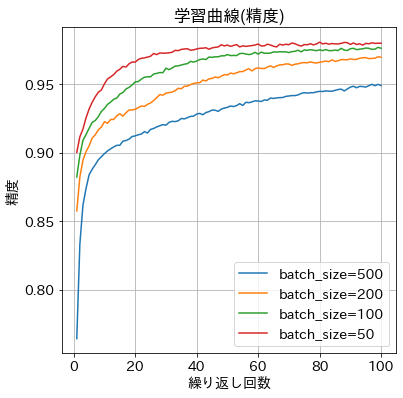

In [ ]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,4], label='batch_size=500')
plt.plot(history3[:,0], history3[:,4], label='batch_size=200')
plt.plot(history4[:,0], history4[:,4], label='batch_size=100')
plt.plot(history5[:,0], history5[:,4], label='batch_size=50')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
create_pdf(plt)
plt.show()